In [1]:
# package needed to work with visualisation of location data
# I dont know why i cant install geopandas using pip but using conda installer
!conda install geopandas

Solving environment: ...working... done

# All requested packages already installed.



In [2]:
# package needed to work with visualisation of location data
!pip install descartes

In [3]:
# package needed to work with shapes and polygens (judge the area of different boroughs)
!pip install shapely

In [4]:
## These are the packages needed for the dashboard

!pip install dash 
!pip install plotly
!pip install chartstudio
!pip install dash_daq

  Could not find a version that satisfies the requirement chartstudio (from versions: )
No matching distribution found for chartstudio


In [ ]:
# these are the machine learning package 
#  keras package are now under tensorflow package    used for ANN model
!pip install tensorflow
#  for random forest method
# !pip install sklearn     


In [1]:
import urllib.request    # for downloading data
import scipy.stats as stats
import seaborn as sns
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import descartes
from shapely.geometry import Point, Polygon
from geopandas import GeoDataFrame, GeoSeries
sns.set_style("whitegrid")


%matplotlib inline

---
---
## QUESTION 1
- Programmatically download and load into your favorite analytical tool the trip data for Sept 2015.
- Report how many rows and columns of data you have loaded.

In [2]:
### if you dont want to waiting for downloading and you have the dataset ready,
### just comment and disable the first section 

### The question asked for programmical download and load, but for convenience,
### we could simply use following code 
### dataset = pd.read_csv('https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv',engine='python')

print('Beginning file download from website...')
url = 'https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv'
urllib.request.urlretrieve(url, 'green_tripdata_2015-09.csv')
print('File download successfully')


print('Loading Dataset')
original_data = pd.read_csv('green_tripdata_2015-09.csv',engine='python')
dataset = original_data.copy()

n_row,n_col = np.shape(dataset)
print ('The number of rows are {}'.format(n_row))
print ('The number of columns are {}'.format(n_col))

# here I rename 'Trip_type ' to 'Trip_type' for easier data manipualtion
dataset = dataset.rename(columns = {'Trip_type ':'Trip_type'})
print(list(dataset))

Beginning file download from website...
File download successfully
Loading Dataset
The number of rows are 1494926
The number of columns are 21
['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime', 'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude', 'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude', 'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax', 'Tip_amount', 'Tolls_amount', 'Ehail_fee', 'improvement_surcharge', 'Total_amount', 'Payment_type', 'Trip_type']


**As showed above, there are total 1494926 rows and 21 columns**

---
---
## QUESTION 2
- Plot a histogram of the number of the trip distance ("Trip Distance").
- Report any structure you find and any hypotheses you have about that structure.

**Before we do any analysis and data manipulation, let's remove the invalid data**

According to the dataset description (https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page), there are the rules for the data:
- VendorID:                1 or 2 
- RateCodeID:              1 - 6
- Store_and_fwd_flag:      Y or N
- Payment_type:            1 - 6
- Trip_type:               1 or 2



In [8]:
print('data in VendorID are:           ' + str(dataset.VendorID.unique()))
print('data in RateCodeID are:         ' + str(dataset.RateCodeID.unique()))
print('data in Store_and_fwd_flag are: ' + str(dataset.Store_and_fwd_flag.unique()))
print('data in Payment_type are:       ' + str(dataset.Payment_type.unique()))
print('data in Trip_type are:          ' + str(dataset.Trip_type.unique()))

data in VendorID are:           [2 1]
data in RateCodeID are:         [ 5  1  2  4  3 99  6]
data in Store_and_fwd_flag are: ['N' 'Y']
data in Payment_type are:       [1 2 3 4 5]
data in Trip_type are:          [ 2.  1. nan]


In [9]:
# check if anymore data is missing
dataset.isna().sum()

VendorID                       0
lpep_pickup_datetime           0
Lpep_dropoff_datetime          0
Store_and_fwd_flag             0
RateCodeID                     0
Pickup_longitude               0
Pickup_latitude                0
Dropoff_longitude              0
Dropoff_latitude               0
Passenger_count                0
Trip_distance                  0
Fare_amount                    0
Extra                          0
MTA_tax                        0
Tip_amount                     0
Tolls_amount                   0
Ehail_fee                1494926
improvement_surcharge          0
Total_amount                   0
Payment_type                   0
Trip_type                      4
dtype: int64

**Here we could see there are invalid data in Trip_type and RateCodeID**

In [10]:
dataset = dataset.dropna(subset=['Trip_type'])
dataset = dataset.loc[dataset['RateCodeID']!=99,:]
np.shape(dataset)

(1494920, 21)

As see above, 6 rows of data are removed. 

Now, let's go back to the question, histogram of trip distance. During the coding process, I first found several entry of travel distane being zero but the pick-up and Drop-off longitude are different. This indicates the data is missing becasue of data was not recorded rather than the travel distance is really zero. Hence, I remove those zero data in the histogram.

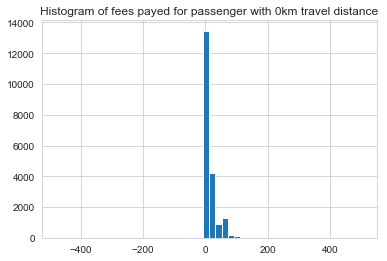

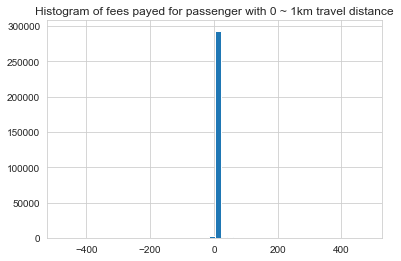

In [11]:
plt.hist(dataset.loc[dataset['Trip_distance']==0,'Total_amount'],bins=50)
plt.title('Histogram of fees payed for passenger with 0km travel distance')
plt.show()
plt.hist(dataset.loc[(dataset['Trip_distance']>0) & (dataset['Trip_distance']<1),'Total_amount'],bins=50)
plt.title('Histogram of fees payed for passenger with 0 ~ 1km travel distance')
plt.show()

**We could see that passenger with zero travel distance actually has different fees paid (where other distance usually have the majority of the fees fixed in a certain range). This shows the travel distance being 0 is wrong (maybe because the data fail to be uploaded), it should not be 0. Hence, I remove the zero entries in the dataset**

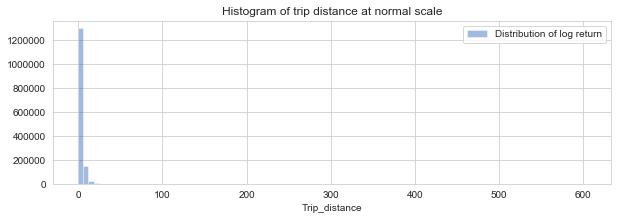

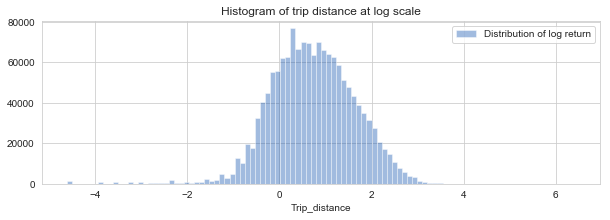

In [12]:
dataset = dataset.loc[dataset['Trip_distance']!=0,:]

plt.figure(figsize=(10,3))
sns.distplot(dataset.Trip_distance, color='b', bins=100, kde=False,
            hist_kws = {"linewidth": 1,"alpha": 0.4, "color": "#1555af"}
            );
plt.legend(['Distribution of log return'])
plt.title('Histogram of trip distance at normal scale')
plt.show()


plt.figure(figsize=(10,3))
sns.distplot(np.log(dataset.Trip_distance), color='b', bins=100, kde=False,
            hist_kws = {"linewidth": 1,"alpha": 0.4, "color": "#1555af"}
            );
plt.legend(['Distribution of log return'])
plt.title('Histogram of trip distance at log scale')
plt.show()

Based on the observation and the shape of distribution, I have **two hypotheses**: 
1. The data is on expnential distribtuion.
2. The data is on log-normal distribution. ( log(x) is normally distributed )



#### Part (A): working on exponential distribution hypotheses

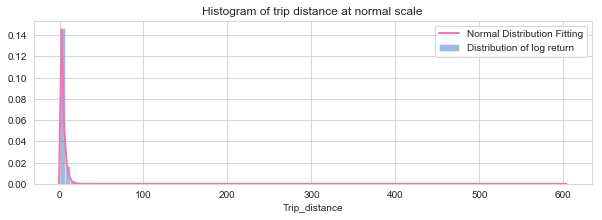

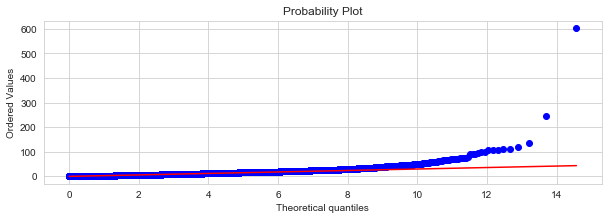

Statistic: 29339.984
P-value 0.150: 0.922, data does not look normal (reject H0)
P-value 0.100: 1.078, data does not look normal (reject H0)
P-value 0.050: 1.341, data does not look normal (reject H0)
P-value 0.025: 1.606, data does not look normal (reject H0)
P-value 0.010: 1.957, data does not look normal (reject H0)


In [13]:
##########################################################
###### Method 1: look at the fitting of the curve   ######
##########################################################
plt.figure(figsize=(10,3))
sns.distplot(dataset.Trip_distance, color='b', bins=100,
            kde=False,
            hist_kws = {"linewidth": 1,"alpha": 0.4, "color": "#1555af"},
            fit=stats.expon, fit_kws  = {'color':'#ef76af','lw':2}
            );
plt.legend(['Normal Distribution Fitting','Distribution of log return'])
plt.title('Histogram of trip distance at normal scale')

plt.show()


##########################################################
######          Method 2: look at the qq-plot       ######
##########################################################
plt.figure(figsize=(10,3))
stats.probplot(dataset.Trip_distance, dist="expon", plot=plt)
plt.show()


##########################################################
######    Method 3: look at anderson-test p-value   ######
##########################################################

result = stats.anderson((dataset.Trip_distance), dist='expon')
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('P-value %.3f: %.3f, data looks normal (fail to reject H0)' % (sl/100, cv))
    else:
        print('P-value %.3f: %.3f, data does not look normal (reject H0)' % (sl/100, cv))

**Conclusion for exponential distribution hypotheses:**

This distribution of the trip distance even though looks like a exponential distribution, but we do not have enough evidence to prove this is indeed exponential distribution. Hence, data does not look exponentially distributed.


#### Part (B): working on log-normal distribution hypotheses

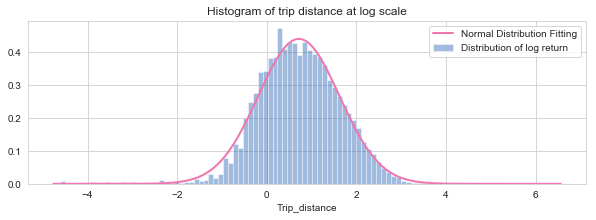

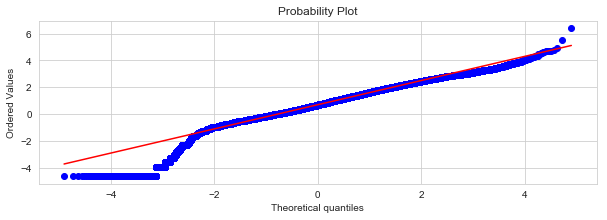

Statistic: 1337.156
P-value 0.150: 0.576, data does not look normal (reject H0)
P-value 0.100: 0.656, data does not look normal (reject H0)
P-value 0.050: 0.787, data does not look normal (reject H0)
P-value 0.025: 0.918, data does not look normal (reject H0)
P-value 0.010: 1.092, data does not look normal (reject H0)


In [14]:
##########################################################
###### Method 1: look at the fitting of the curve   ######
##########################################################
plt.figure(figsize=(10,3))
sns.distplot(np.log(dataset.Trip_distance),color='b',bins=100,
            kde=False,
            hist_kws = {"linewidth": 1,"alpha": 0.4, "color": "#1555af"},
            fit=stats.norm, fit_kws  = {'color':'#ef76af','lw':2}
            );
plt.legend(['Normal Distribution Fitting','Distribution of log return'])
plt.title('Histogram of trip distance at log scale')
plt.show()


##########################################################
######          Method 2: look at the qq-plot       ######
##########################################################
plt.figure(figsize=(10,3))
stats.probplot(np.log(dataset.Trip_distance), dist="norm",plot=plt)
plt.show()


##########################################################
######    Method 3: look at anderson-test p-value   ######
##########################################################

result = stats.anderson(np.log(dataset.Trip_distance), dist='norm')
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('P-value %.3f: %.3f, data looks normal (fail to reject H0)' % (sl/100, cv))
    else:
        print('P-value %.3f: %.3f, data does not look normal (reject H0)' % (sl/100, cv))
        
        



**Conclusion for log-normal distribution hypotheses:**

This distribution of the trip distance even though looks like a log-normal distribution, but again, we do not have enough evidence to prove this is indeed log-normal distribution.

---
--- 


## QUESTION 3:
- Report mean and median trip distance grouped by hour of day.


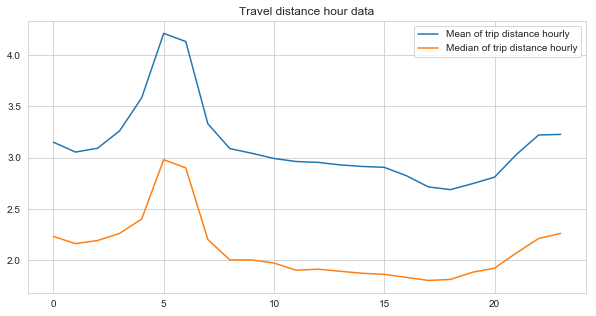

Mean and median trip distance grouped by hour of day is shown below: 

pickup_hour                  0         1         2         3         4
mean   Trip_distance  3.150602  3.054612  3.091807  3.261706  3.584065
median Trip_distance  2.230000  2.160000  2.190000  2.260000  2.400000

pickup_hour                  5         6         7         8         9
mean   Trip_distance  4.214483  4.134494  3.330973  3.088413  3.042416
median Trip_distance  2.980000  2.900000  2.200000  2.000000  2.000000

pickup_hour                 10        11        12        13        14
mean   Trip_distance  2.991911  2.962246  2.953734  2.929103  2.913916
median Trip_distance  1.970000  1.900000  1.910000  1.890000  1.870000

pickup_hour                 15       16        17        18        19
mean   Trip_distance  2.905159  2.82362  2.713986  2.687323  2.745756
median Trip_distance  1.860000  1.83000  1.800000  1.810000  1.880000

pickup_hour                 20        21        22        23
mean   Trip_dis

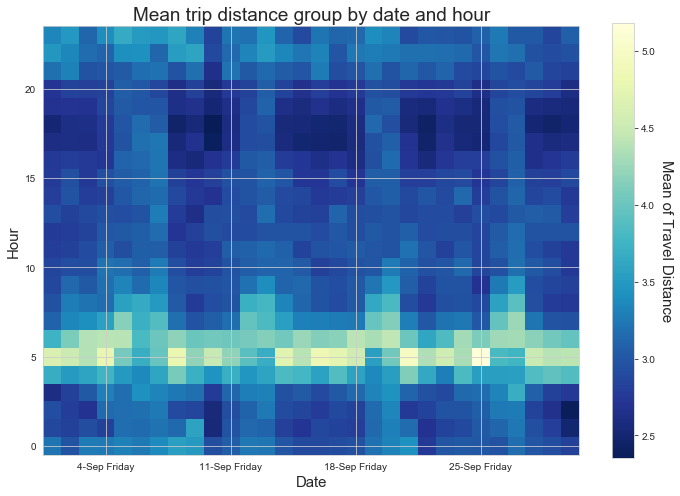

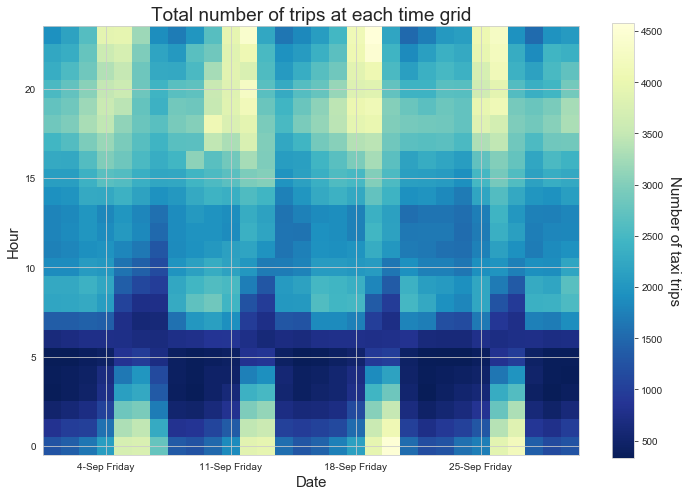

In [15]:

# here I write function because i would need to do the same thing on another data set
def plot_time(dataset):
    # convert the string to datetime format and extract hour and date from the data 
    dataset.loc[:,'lpep_pickup_datetime'] = pd.to_datetime(dataset.loc[:,'lpep_pickup_datetime'])
    dataset.loc[:,'pickup_day'] = dataset.loc[:,'lpep_pickup_datetime'].dt.day
    dataset.loc[:,'pickup_hour'] = dataset.loc[:,'lpep_pickup_datetime'].dt.hour

    # use pivotable function to calculate mean and median trip traveled
    hour_data = pd.pivot_table(dataset.loc[:,['pickup_hour','Trip_distance']],
                                 index   = ["pickup_hour"],
                                 values  = ["Trip_distance"],
                                 aggfunc = [np.mean, np.median])

    plt.figure(figsize=(10,5))
    plt.plot(hour_data.index,hour_data.iloc[:,0], label = 'Mean of trip distance hourly')
    plt.plot(hour_data.index,hour_data.iloc[:,1], label = 'Median of trip distance hourly')
    plt.legend()
    plt.title('Travel distance hour data')
    plt.show()

    print('Mean and median trip distance grouped by hour of day is shown below: \n')
    for i in range(5):
        print(hour_data.iloc[5*i:5*(i+1),:].T)
        print('')


    # average trip time
    daily_data = pd.pivot_table(dataset.loc[:,['pickup_day','pickup_hour','Trip_distance']],
                                 index   = ["pickup_hour"],
                                 columns  = ['pickup_day'],
                                 values  = ["Trip_distance"],
                                 aggfunc = [np.mean]) 
    # frequency (number of trips within each time grid)
    daily_data2 = pd.pivot_table(dataset.loc[:,['pickup_day','pickup_hour','Trip_distance']],
                                 index   = ["pickup_hour"],
                                 columns  = ['pickup_day'],
                                 values  = ["Trip_distance"],
                                 aggfunc = ['count'])  
    
    fig, ax = plt.subplots(figsize=(12,8))
    im = ax.imshow(daily_data,cmap='YlGnBu_r',origin='lower', interpolation='nearest')
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Mean of Travel Distance',rotation=-90, va="bottom", fontsize=15)
    plt.title('Mean trip distance group by date and hour', fontsize=19)
    plt.xlabel('Date', fontsize=15)
    plt.ylabel('Hour', fontsize=15)
    ax.set_xticks(np.arange(3,30,7))
    ax.set_xticklabels(['{}-Sep Friday'.format(7*i+4) for i in range(4)])
    plt.show()
    
    fig, ax = plt.subplots(figsize=(12,8))
    im = ax.imshow(daily_data2,cmap='YlGnBu_r',origin='lower', interpolation='nearest')
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Number of taxi trips',rotation=-90, va="bottom", fontsize=15)
    plt.title('Total number of trips at each time grid', fontsize=19)
    plt.xlabel('Date', fontsize=15)
    plt.ylabel('Hour', fontsize=15)
    ax.set_xticks(np.arange(3,30,7))
    ax.set_xticklabels(['{}-Sep Friday'.format(7*i+4) for i in range(4)])
    plt.show()
        
    
    
    return None

# backup the original dataset
new_data = dataset.copy()
plot_time(new_data)

(04-Sep-2015 is Friday on the Calendar)

(A) trip distance:

As above, from figure 1, we could see the peak of mean and median of distance travel is peaked at 5 and 6 a.m. The underlying reason is that this is the time for long distance commuter to take the taxi to go to work. The the time approach 9 am, the people who take taxi later tend to be closer to their destination. Hence the mean distance traveled droped significantly.

From figure 2, if we also look at different dateswe could see significant periodic trend distribtion of mean trip distance. The peak tends to be one hour later in weekend than in weekday. But over the whole month, the peak in travel  distance is at around 5.

(B) Number of trips:

- Generically speaking, there are more taxi trips at night than in the morning even though the distance of travel in the morning is longer. At evening, there are more but shorter taxi travels.
- We could see the peak of taxi travel can last untill 4a.m. in the morining (For people from bar and late night enertainment)

---



**Now let's go to next part of this question**

*"We'd like to get a rough sense of identifying trips that originate or terminate at one of the NYC area airports. Can you provide a count of how many transactions fit this criteria, the average fair, and any other interesting characteristics of these trips."*


**Answer:**
First, I define the location of the three airports (JFK, EWR, LGA), then I create a function to convert the distance in latitude/longitude to difference in Kilometer. Then I assume all travel within 2.5km is the trip originate and terminate at the airport 

In [16]:
 
airport_data = find_airport_data(dataset)

There are 72616 trips fulfill the criteria.


In [17]:
airport_summary = pd.pivot_table(airport_data.loc[:,['Airport','Fare_amount','Total_amount','VendorID']],
                                    index   = ["Airport"],
                                    aggfunc = {'Total_amount':np.mean,
                                               'Fare_amount' :np.mean,
                                               'VendorID'    :'count'},
                                    margins = True
                                ).rename(columns={'VendorID':'Numer of transactions',
                                                  'Total_amount': 'Mean of Total_amount',
                                                  'Fare_amount' : 'Mean of Fare_amount'})

airport_summary

,Mean of Fare_amount,Mean of Total_amount,Numer of transactions
Airport,,,
EWR,75.992908,97.766340,705
JFK,41.231788,48.297325,13037
LGA,14.316244,17.437145,58874
All,19.747278,23.757464,72616


Text(0.5, 1.0, 'Total taxi fare for all airport trip')

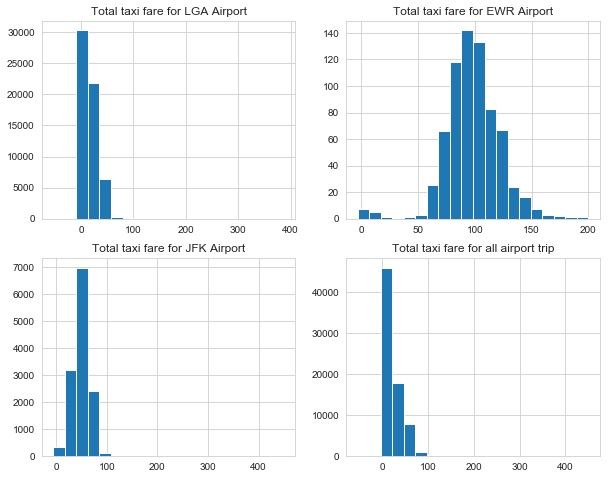

In [18]:
plt.figure(figsize=(10,8))
for n,i in enumerate(airports):
    plt.subplot(2,2,n+1)
    plt.hist(airport_data.loc[airport_data['Airport']==i,'Total_amount'],bins=20)
    plt.title('Total taxi fare for ' + i + ' Airport')
plt.subplot(2,2,4)
plt.hist(airport_data.loc[:,'Total_amount'],bins=20)
plt.title('Total taxi fare for all airport trip')

We could see there are different distribution trend for LGA is totally different to that of the trips travelling to EWR and JFK. One reason is that if we look at the map, LGA lies in the city center, which is much closer to the city center than the other two airports. 

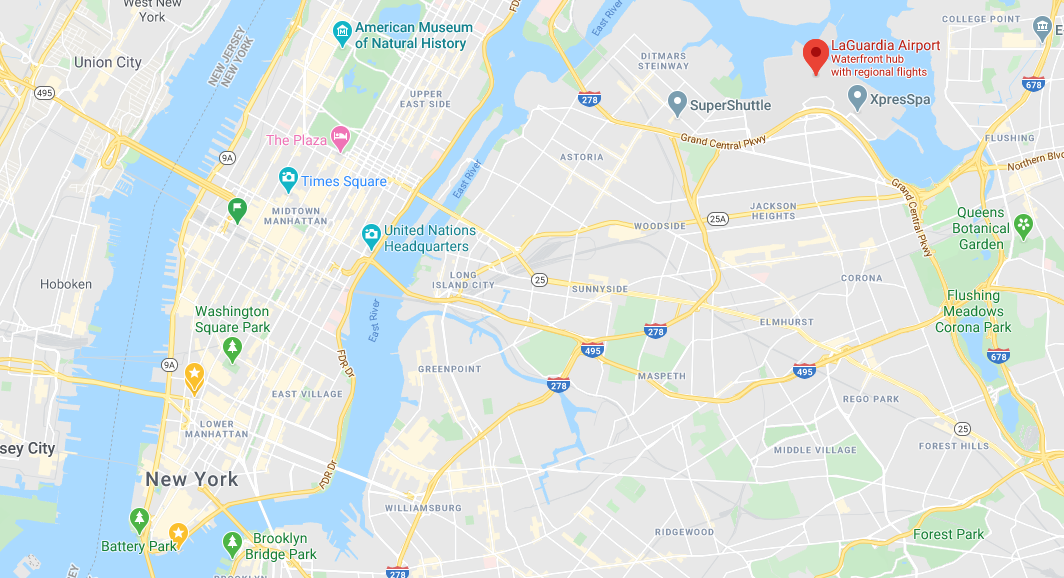*Source:  my own google map screenshot*


This means it is much easier for people take the taxi to the airport (more affordable). This explains there are 58874 trips to LGA, but only 13037 and 705 trips to JFK and EWR airport. In addition, it also explains the different distribution in taxi charges. 
- For the trips to LGA, it is majorly less tha 40 dollars, and the amount of transaction decrease exponentially with increase taxi fair.
- For trips to JFK and EWR, there is very little trips that has the taxi price lower than 40 dollars. Especially for EWR airport, major of the trip costs more than 100 dollars. This also reflects EWR is the most distant airport to New York City comparing to other two airports.

**Now let's see if there is any difference in time distribution**

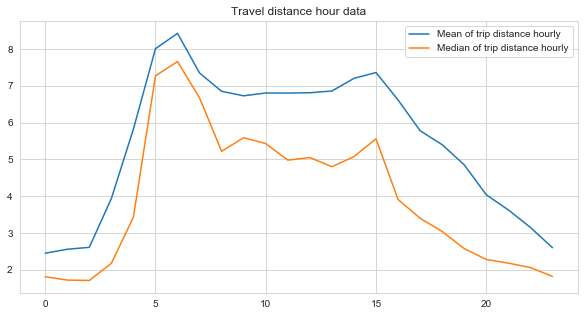

Mean and median trip distance grouped by hour of day is shown below: 

pickup_hour                  0         1         2         3         4
mean   Trip_distance  2.450714  2.557606  2.609609  3.936081  5.823502
median Trip_distance  1.810000  1.720000  1.710000  2.175000  3.430000

pickup_hour                  5        6         7         8         9
mean   Trip_distance  8.008346  8.42529  7.347605  6.849112  6.727955
median Trip_distance  7.270000  7.66000  6.670000  5.220000  5.590000

pickup_hour                 10        11        12        13        14
mean   Trip_distance  6.804998  6.802957  6.811337  6.858213  7.202223
median Trip_distance  5.430000  4.980000  5.050000  4.800000  5.075000

pickup_hour                 15        16        17        18        19
mean   Trip_distance  7.361613  6.614296  5.778436  5.399681  4.851311
median Trip_distance  5.560000  3.910000  3.400000  3.040000  2.575000

pickup_hour                 20        21        22        23
mean   Trip_dis

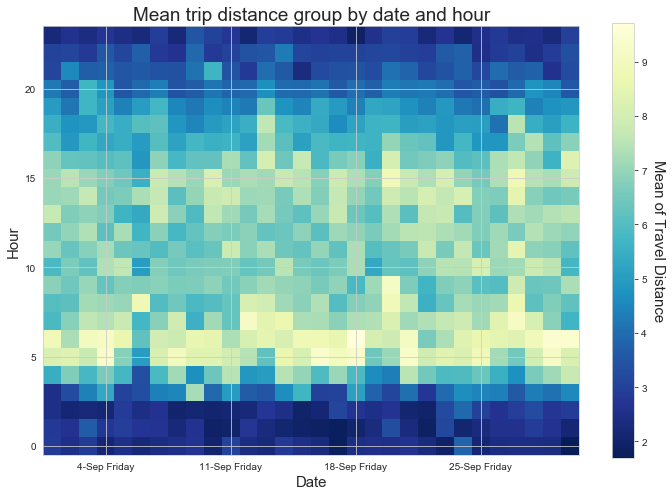

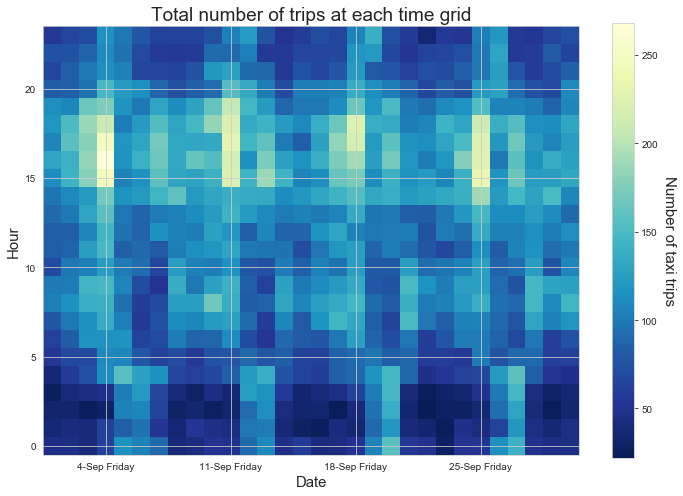

In [19]:
plot_time(airport_data)

(A) distance of travel:
- From figure 1 and 2, we could see the travel distance is sustained, stable and high during the day time. This is because the travel distance from city center to the airport is similar. 8 miles on the highway and 0~4 miles inside the New York City. 
- The travel distance is significantly shorter in the night. This is becasue there no much flight during the night. And most fo the travel should be traveling from airport to the nearby hotel for staying overnight. (from my perosnal experience, If i got a flght at 6am, I would choose to live in a hotel nearby the airport for the night before the flight)

(B) Number of Trips:
- Look at figure 3, We could see the highest number of taxi travel at airport is actually at Friday from 15:00 to 20:00. 
- This is very understandable. People who are working will take the flight on Friday to reduce the overall impact on their careers and works.

___
___

## Question 4:
- Build a derived variable for tip as a percentage of the total fare.
- Build a predictive model for tip as a percentage of the total fare. Use as much of the data as you like (or all of it). We will validate a sample.

**Let me show you the result first**
I decided to build a combined model to first use classification method to decide whether a tip is paid and then use regression method to decide if the tip is paid, what percentage do they pay. And here is the feature i used:
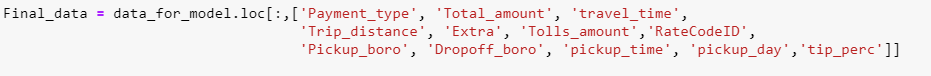
And here is the result on testing dataset:
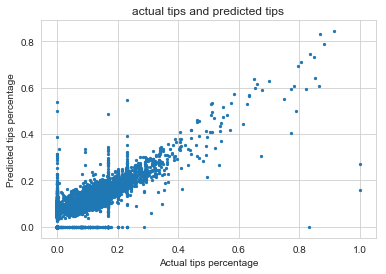
Mean Square Error is 0.0006842738129616408.  The result is absolutely amazing (better than what i expected). 

Scroll down the page and you will understand how I select the model, clean the data, select and preprocess the feature and finally, train the final ensemble model. It will be a bit long by the way.... 

In [20]:
list(dataset)

['VendorID',
 'lpep_pickup_datetime',
 'Lpep_dropoff_datetime',
 'Store_and_fwd_flag',
 'RateCodeID',
 'Pickup_longitude',
 'Pickup_latitude',
 'Dropoff_longitude',
 'Dropoff_latitude',
 'Passenger_count',
 'Trip_distance',
 'Fare_amount',
 'Extra',
 'MTA_tax',
 'Tip_amount',
 'Tolls_amount',
 'Ehail_fee',
 'improvement_surcharge',
 'Total_amount',
 'Payment_type',
 'Trip_type']

In [21]:
# Build a variable 'tip_perc', which represents the percentage of the total fare
new_data = dataset.copy()
new_data['tip_perc'] = new_data['Tip_amount']/new_data['Total_amount'].values
new_data.head()

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,Extra,MTA_tax,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type,tip_perc
2,2,2015-09-01 00:01:50,2015-09-01 00:04:24,N,1,-73.921410,40.766708,-73.914413,40.764687,1,...,0.5,0.5,0.50,0.0,NaN,0.3,5.80,1,1.0,0.086207
3,2,2015-09-01 00:02:36,2015-09-01 00:06:42,N,1,-73.921387,40.766678,-73.931427,40.771584,1,...,0.5,0.5,0.00,0.0,NaN,0.3,6.30,2,1.0,0.000000
4,2,2015-09-01 00:00:14,2015-09-01 00:04:20,N,1,-73.955482,40.714046,-73.944412,40.714729,1,...,0.5,0.5,0.00,0.0,NaN,0.3,6.30,2,1.0,0.000000
5,2,2015-09-01 00:00:39,2015-09-01 00:05:20,N,1,-73.945297,40.808186,-73.937668,40.821198,1,...,0.5,0.5,1.36,0.0,NaN,0.3,8.16,1,1.0,0.166667
6,2,2015-09-01 00:00:52,2015-09-01 00:05:50,N,1,-73.890877,40.746426,-73.876923,40.756306,1,...,0.5,0.5,0.00,0.0,NaN,0.3,7.80,1,1.0,0.000000


### Step 1: Data Pre-Processing and log tranformation

**Content**:
- Choose of approach
- Discretisation of continuous variable
- Distribution check and deal with long tails
- Correlation check
- Transform location into Boroughs



### Choose of approach

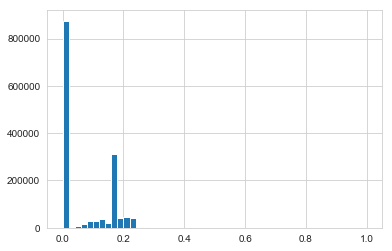

In [22]:
new_data.tip_perc.hist(bins=50)

Look at the histogram of the percentage, we could see major of people are simply paying zeros tips. Hence, I decide to build a combined model: 
- firstly, build a classification model on whether people is going to pay a tip
- secondly, build a regression model on how much people is going to pay for the tips

### Discretisation of continuous variable

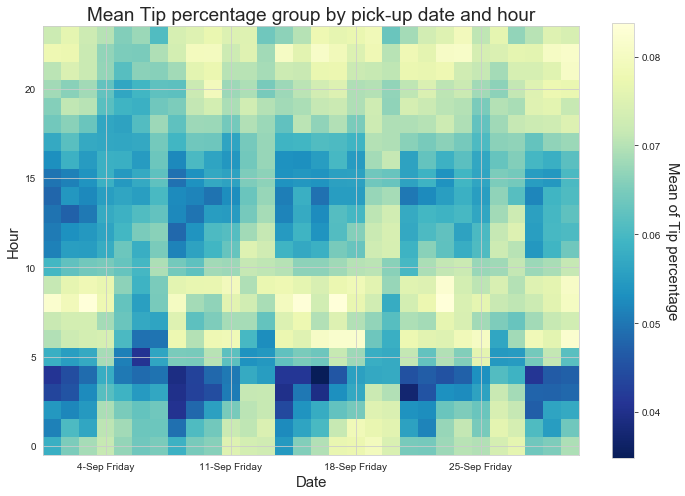

In [23]:
new_data.loc[:,'lpep_pickup_datetime'] = pd.to_datetime(new_data.loc[:,'lpep_pickup_datetime'])
new_data.loc[:,'pickup_day'] = new_data.loc[:,'lpep_pickup_datetime'].dt.day
new_data.loc[:,'pickup_hour'] = new_data.loc[:,'lpep_pickup_datetime'].dt.hour

daily_data = pd.pivot_table(new_data.loc[:,['pickup_day','pickup_hour','tip_perc']],
                             index   = ["pickup_hour"],
                             columns  = ['pickup_day'],
                             values  = ["tip_perc"],
                             aggfunc = [np.mean]) 
fig, ax = plt.subplots(figsize=(12,8))
im = ax.imshow(daily_data,cmap='YlGnBu_r',origin='lower', interpolation='nearest')
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Mean of Tip percentage',rotation=-90, va="bottom", fontsize=15)
plt.title('Mean Tip percentage group by pick-up date and hour', fontsize=19)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Hour', fontsize=15)
ax.set_xticks(np.arange(3,30,7))
ax.set_xticklabels(['{}-Sep Friday'.format(7*i+4) for i in range(4)])
plt.show()


We could see some significant pattern for tip percentage.

- The are 4 distinct time blocks for the mean of tip percentage (0-4, 5-10, 11-17,18-23). Becasue it is not reasonable to have a categorital feature with 24 different categories. In the machine learning next step, I would use this 4 blocks rather than the original 24 different pick-up hours.
- Becasue I see pretty distinct behavior on the tips percentage on different day, I would create a feature of 7 categorys represent Monday to Sunday

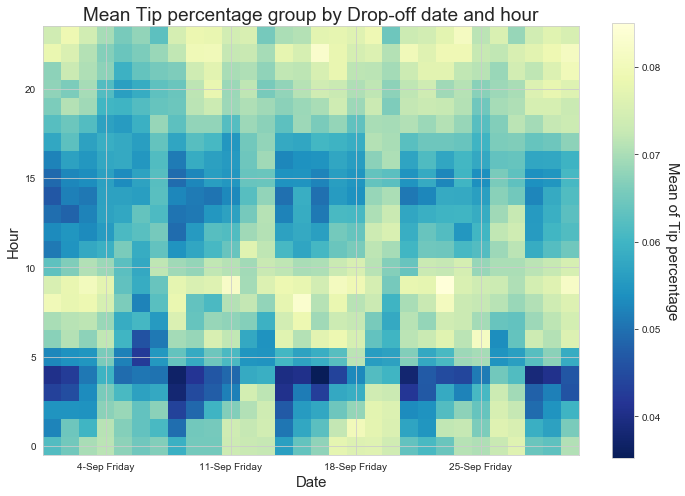

In [24]:
new_data.loc[:,'Lpep_dropoff_datetime'] = pd.to_datetime(new_data.loc[:,'Lpep_dropoff_datetime'])
new_data.loc[:,'dropoff_day'] = new_data.loc[:,'Lpep_dropoff_datetime'].dt.day
new_data.loc[:,'dropoff_hour'] = new_data.loc[:,'Lpep_dropoff_datetime'].dt.hour

daily_data = pd.pivot_table(new_data.loc[:,['dropoff_day','dropoff_hour','tip_perc']],
                             index   = ["dropoff_hour"],
                             columns  = ['dropoff_day'],
                             values  = ["tip_perc"],
                             aggfunc = [np.mean]) 
fig, ax = plt.subplots(figsize=(12,8))
im = ax.imshow(daily_data,cmap='YlGnBu_r',origin='lower', interpolation='nearest')
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Mean of Tip percentage',rotation=-90, va="bottom", fontsize=15)
plt.title('Mean Tip percentage group by Drop-off date and hour', fontsize=19)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Hour', fontsize=15)
ax.set_xticks(np.arange(3,30,7))
ax.set_xticklabels(['{}-Sep Friday'.format(7*i+4) for i in range(4)])
plt.show()


Pattery are almost the same for pickup time heatmap and drop-time heatmap. It also give future evidence to setup 4 time blocks to act as predictive feature.

In [25]:
# change pickup and drop time into 4 blocks 0-4, 5-10, 11-17,18-23


new_data.loc[(new_data['pickup_hour']<=4),'pickup_time'] = '0~4'
new_data.loc[(new_data['pickup_hour']<=10) & (new_data['pickup_hour']>=5),'pickup_time'] = '5~10'
new_data.loc[(new_data['pickup_hour']<=17) & (new_data['pickup_hour']>=11),'pickup_time'] = '11~17'
new_data.loc[(new_data['pickup_hour']<=23) & (new_data['pickup_hour']>=18),'pickup_time'] = '18~23'
new_data.loc[:,'pickup_day'] = new_data.loc[:,'lpep_pickup_datetime'].dt.day_name()

new_data.head()

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,improvement_surcharge,Total_amount,Payment_type,Trip_type,tip_perc,pickup_day,pickup_hour,dropoff_day,dropoff_hour,pickup_time
2,2,2015-09-01 00:01:50,2015-09-01 00:04:24,N,1,-73.921410,40.766708,-73.914413,40.764687,1,...,0.3,5.80,1,1.0,0.086207,Tuesday,0,1,0,0~4
3,2,2015-09-01 00:02:36,2015-09-01 00:06:42,N,1,-73.921387,40.766678,-73.931427,40.771584,1,...,0.3,6.30,2,1.0,0.000000,Tuesday,0,1,0,0~4
4,2,2015-09-01 00:00:14,2015-09-01 00:04:20,N,1,-73.955482,40.714046,-73.944412,40.714729,1,...,0.3,6.30,2,1.0,0.000000,Tuesday,0,1,0,0~4
5,2,2015-09-01 00:00:39,2015-09-01 00:05:20,N,1,-73.945297,40.808186,-73.937668,40.821198,1,...,0.3,8.16,1,1.0,0.166667,Tuesday,0,1,0,0~4
6,2,2015-09-01 00:00:52,2015-09-01 00:05:50,N,1,-73.890877,40.746426,-73.876923,40.756306,1,...,0.3,7.80,1,1.0,0.000000,Tuesday,0,1,0,0~4


### Distribution check

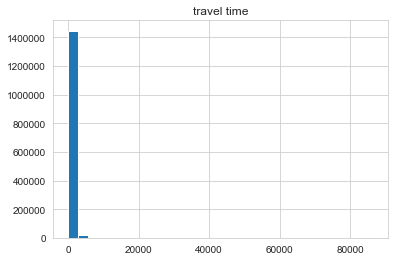

There are 143 zeros values in traveling time


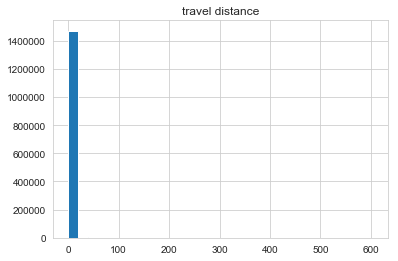

In [26]:
travel_time = (new_data.loc[:,'Lpep_dropoff_datetime'] - new_data.loc[:,'lpep_pickup_datetime']).dt.seconds
plt.hist(travel_time,bins=30)
plt.title('travel time')
plt.show()
print('There are {} zeros values in traveling time'.format(np.sum(travel_time==0)))

plt.hist(new_data.Trip_distance,bins=30)
plt.title('travel distance')
plt.show()

We could see the data for travel distance and traveling time is very long-tailed and inbalanced, I need to take long transfromation. And there are 143 zero values inside the data, which means it is wrong, i need to remove these enrows.

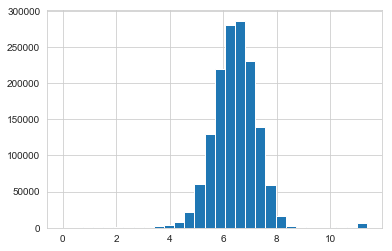

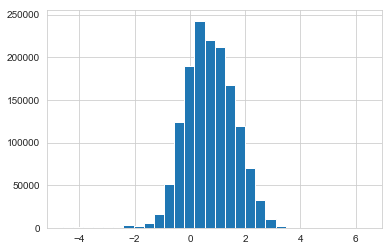

In [27]:
plt.hist(np.log(travel_time[travel_time!=0]),bins=30)
plt.show()

plt.hist(np.log(new_data.Trip_distance),bins=30)
plt.show()

Now the distribtuion of the data is in a more healthy and constructive way

**some more distribution check on numerical entries**

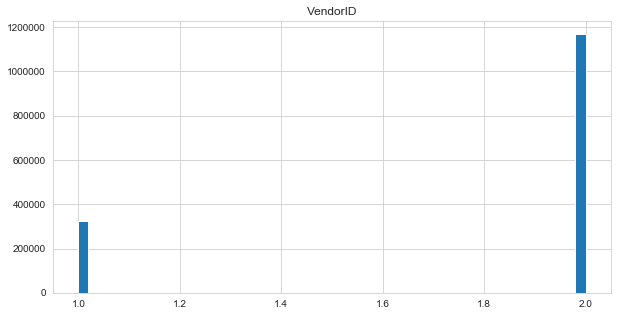

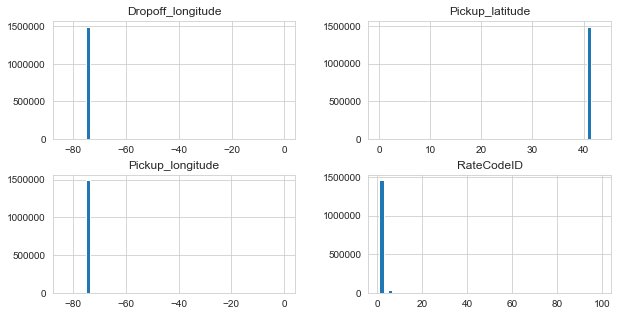

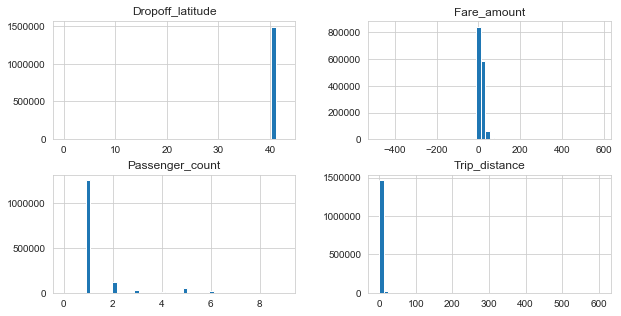

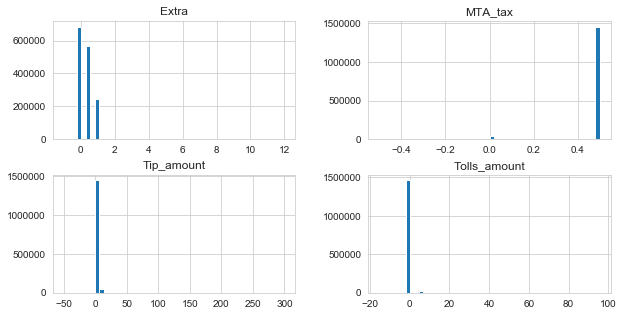

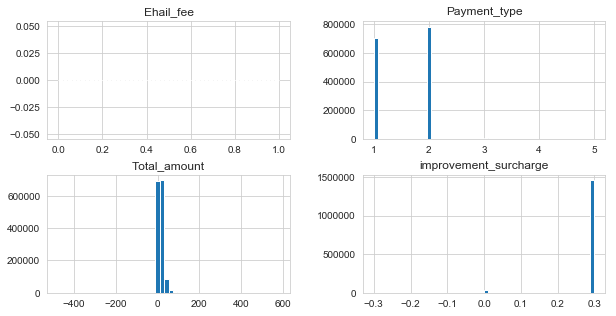

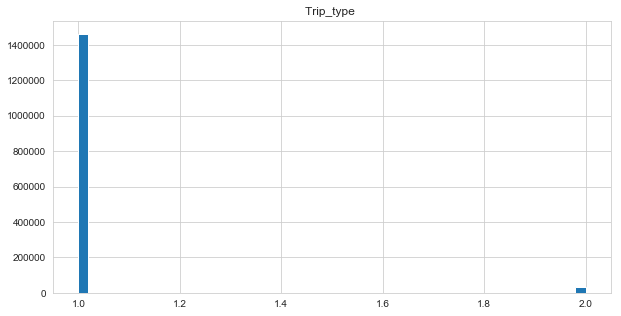

In [28]:
# from question 1, there are 21 entries
for i in range(6):
    original_data.iloc[:,4*i:4*i+4].hist(figsize=(10,5),bins=50)

In summary:

- remove negative : 'Fare_amount','Tip_amount', 'Total_amount' 
- log_transforamtion: 'Fare_amount','Trip_distance', 'Total_amount', 'Travel Time'
- remove: Ehail_fees( too many missing ), Tip_amount(we cannot use tip_amount to predict tip percentage)

### Correlation Check
For numerical entries, let's do a correlation check and removed highly correlated data.

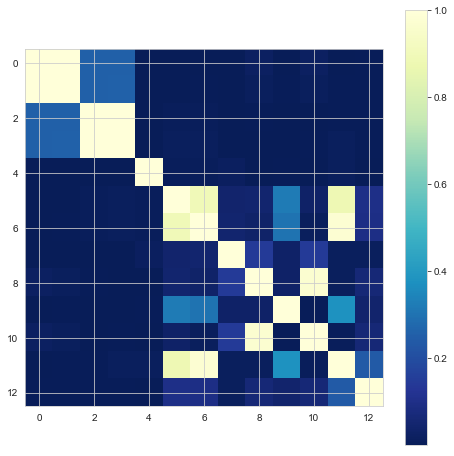

In [29]:
corr = new_data.loc[:,['Pickup_longitude','Pickup_latitude','Dropoff_longitude',
               'Dropoff_latitude','Passenger_count','Trip_distance',
               'Fare_amount','Extra','MTA_tax','Tolls_amount',
               'improvement_surcharge','Total_amount','tip_perc']].corr()
plt.figure(figsize=(8,8))
plt.imshow(abs(corr),cmap='YlGnBu_r')
plt.colorbar()

From correlations, I remove Fare_amount, inprovement_surcharge.

### Transformation of longitude and latitude into boroughs

**Original plan**

This is what I planned to do, transform the location data into borough names, But i realise it would take me so long that it is not realistic to convert all 1million data into bourough names. It took me 14 seconds to convert 10k data. This means I need to wait 6 hours for this algorithm to work. So I leave it here and try to find another way to transform the long/lat data into meaningful information. But if I got enough computational power, I would still work this code

               boro_name    shape_area     shape_leng  \
boro_code                                               
1.0            Manhattan  6.366027e+08  361212.476577   
2.0                Bronx  1.186612e+09  462958.187332   
3.0             Brooklyn  1.937593e+09  738745.840717   
4.0               Queens  3.045878e+09  904188.424111   
5.0        Staten Island  1.623756e+09  325960.628294   

                                                    geometry  
boro_code                                                     
1.0        (POLYGON ((-74.01092841268031 40.6844914725429...  
2.0        (POLYGON ((-73.89680883223774 40.7958084451597...  
3.0        (POLYGON ((-73.86706149472118 40.5820879767934...  
4.0        (POLYGON ((-73.83668274106707 40.5949466970158...  
5.0        (POLYGON ((-74.05050806403247 40.5664220341608...  


'\nDont run this code, It would take one hour\nDont run this code, It would take one hour\n'

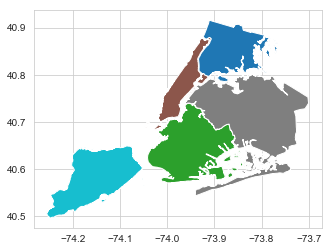

In [30]:
# download the borough data from website https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
boros = GeoDataFrame.from_file('./Borough Boundaries/geo_export_3aad48b7-65d5-492a-8d4c-820506f10f1c.shp')
boros = boros.set_index('boro_code')
boros = boros.sort_index()
print(boros)
# Plot and color by borough
boros.plot(column = 'boro_name')


'''
Dont run this code, It would take one hour
Dont run this code, It would take one hour
'''
# pickup_loc  = GeoSeries([Point(x, y) for x, y in zip(new_data.Pickup_longitude, new_data.Pickup_latitude)]) 
# dropoff_loc = GeoSeries([Point(x, y) for x, y in zip(new_data.Dropoff_longitude, new_data.Dropoff_latitude)])
# new_data.loc[:,'Pickup_boro'] = 'outside'
# new_data.loc[:,'Dropoff_boro'] = 'outside'
# for i in range(1,6):
#     print('Currently working on borough ' + boros.boro_name[i])
#     pickup_idx = pickup_loc.within(boros.geometry[i])
#     dropoff_idx = dropoff_loc.within(boros.geometry[i])
#     new_data.loc[pickup_idx,'Pickup_boro'] = boros.boro_name[i]
#     new_data.loc[dropoff_idx,'Dropoff_boro'] = boros.boro_name[i]
# new_data

**New plan:   classify by approximation**

To resolve the isssue, I decided to **approximate** the boundary of the borough. But this is not really recommended if having the access to enough computational power. But this time the computation would be **1000 times faster**, it only takes 14 seconds to deal with 1million rows of data for 1 jusdgement. Overall, the following code takes around **4mins**. If you still feel this is too long, change 0.008 to a smaller number

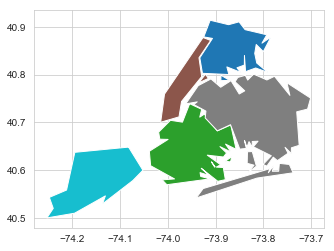

In [31]:
boros = GeoDataFrame.from_file('./Borough Boundaries/geo_export_3aad48b7-65d5-492a-8d4c-820506f10f1c.shp')
boros = boros.set_index('boro_code')
for k in range(1,6):
    boros.loc[[k],'geometry'] = boros.loc[[k],'geometry'].simplify(0.008,False).values
boros.plot(column = 'boro_name')

We could see the approximation is still pretty accurate, I will use this approximation for classify the borough the trip is in

In [32]:
def convert_borough(input_data):
    new_data = input_data.copy()
    print('initialize the pickup locations of taxi trips')
    pickup_loc  = GeoSeries([Point(x, y) for x, y in zip(new_data.Pickup_longitude, new_data.Pickup_latitude)]) 
    print('initialize the drop off locations of taxi trips')
    dropoff_loc = GeoSeries([Point(x, y) for x, y in zip(new_data.Dropoff_longitude, new_data.Dropoff_latitude)])
    new_data.loc[:,'Pickup_boro'] = 'outside'
    new_data.loc[:,'Dropoff_boro'] = 'outside'
    boros = GeoDataFrame.from_file('./Borough Boundaries/geo_export_3aad48b7-65d5-492a-8d4c-820506f10f1c.shp')
    for i in range(5):
        print ('working on pickups in ' + boros.boro_name[i])
        pickup_idx = pickup_loc.within(boros.loc[i,'geometry'].simplify(0.008,False))
        new_data.loc[pickup_idx.values,'Pickup_boro'] = boros.boro_name[i]

        print ('working on dropoffs in ' + boros.boro_name[i])
        dropoff_idx = dropoff_loc.within(boros.loc[i,'geometry'].simplify(0.008,False))
        new_data.loc[dropoff_idx.values,'Dropoff_boro'] = boros.boro_name[i]
    return new_data



### Step 2: Sumarise data manipulation and cleaning

Combined all the analysis above, here comes the summarised version of data cleaning. This function will help you to implement model on a new dataset. It will take 5 mins as it takes time to allocate longtitude and latitude into diferent boroughs

In [33]:
def data_cleaning(input_data):
    '''
    This function just aims to do all the data cleaning and manipulation
    It would be easier for you load new dataset for testing 
    this would takes 5 mins. All the time was spent on the getting the borough name
    '''
    dataset = input_data.copy()
    dataset = dataset.rename(columns = {'Trip_type ':'Trip_type'})
    dataset = dataset.dropna(subset=['Trip_type'])
    dataset = dataset.loc[dataset['RateCodeID']!=99,:]
    dataset = dataset.loc[dataset['Trip_distance']!=0,:]
    
    dataset.loc[:,'lpep_pickup_datetime'] = pd.to_datetime(dataset.loc[:,'lpep_pickup_datetime'])
    dataset.loc[:,'pickup_day'] = dataset.loc[:,'lpep_pickup_datetime'].dt.day
    dataset.loc[:,'pickup_hour'] = dataset.loc[:,'lpep_pickup_datetime'].dt.hour
    dataset.loc[:,'Lpep_dropoff_datetime'] = pd.to_datetime(dataset.loc[:,'Lpep_dropoff_datetime'])
    dataset.loc[:,'dropoff_day'] = dataset.loc[:,'Lpep_dropoff_datetime'].dt.day
    dataset.loc[:,'dropoff_hour'] = dataset.loc[:,'Lpep_dropoff_datetime'].dt.hour
    
    dataset.loc[(dataset['pickup_hour']<=4),'pickup_time'] = '0~4'
    dataset.loc[(dataset['pickup_hour']<=10) & (dataset['pickup_hour']>=5),'pickup_time'] = '5~10'
    dataset.loc[(dataset['pickup_hour']<=17) & (dataset['pickup_hour']>=11),'pickup_time'] = '11~17'
    dataset.loc[(dataset['pickup_hour']<=23) & (dataset['pickup_hour']>=18),'pickup_time'] = '18~23'
    
    dataset.loc[:,'pickup_day'] = dataset.loc[:,'lpep_pickup_datetime'].dt.day_name()
    dataset.loc[:,'travel_time'] = (dataset.loc[:,'Lpep_dropoff_datetime'] - dataset.loc[:,'lpep_pickup_datetime']).dt.seconds
    dataset = dataset.loc[dataset['travel_time']!=0,:]
       
    dataset = dataset.loc[dataset['Total_amount']>0,:]
    dataset['tip_perc'] = dataset ['Tip_amount']/ dataset ['Total_amount'].values

    print('adding information for airport')
    threshold = 2.5
    airports = ['LGA','EWR','JFK']
    dataset['Airport'] = 'outside'
    # then we select the data that travel to and from airport from the dataset
    for i in airports:
        # select both pickup location and dropoff location
        judge = dis_filter(dataset['Pickup_longitude'], dataset['Pickup_latitude'], 
                    airport_loc[i], threshold) | \
                dis_filter(dataset['Dropoff_longitude'], dataset['Dropoff_latitude'], 
                    airport_loc[i], threshold)
        dataset.loc[judge,'Airport'] = i
    dataset = convert_borough(dataset)
    return dataset

def data_transformation(input_data):
    dataset = input_data.copy()
    # follow from last question, all the log_transformation are conducted here
    dataset.loc[:,'travel_time'] = np.log(dataset.loc[:,'travel_time'])
    dataset.loc[:,'Trip_distance'] = np.log(dataset.loc[:,'Trip_distance'])
    dataset.loc[:,'Total_amount'] = np.log(dataset.loc[:,'Total_amount'])
    dataset = dataset.drop(columns = ['lpep_pickup_datetime','Lpep_dropoff_datetime',
                       'Ehail_fee','pickup_hour','dropoff_day', 'dropoff_hour'
                       ,'Tip_amount','Fare_amount','improvement_surcharge',
                        'Pickup_longitude','Pickup_latitude',
                         'Dropoff_longitude','Dropoff_latitude'])
    return dataset


## cleaned_data would be used for next section dashboard to use
cleaned_data = data_cleaning(original_data)
# i saved it so I dont have to wait for another 5 minutes to generate the data
# But it tooks 1 minute to save it locally. Must save it for the second section to work if 
# you choose to run my second section in python console not ipython notebook
cleaned_data.to_csv('cleaned_data.csv')  

#cleaned_data = pd.read_csv('cleaned_data.csv',index_col=0)


## this is the data I am going to use for machine learning
data_for_model = data_transformation(cleaned_data)

adding information for airport
initialize the pickup locations of taxi trips
initialize the drop off locations of taxi trips
working on pickups in Bronx
working on dropoffs in Bronx
working on pickups in Staten Island
working on dropoffs in Staten Island
working on pickups in Brooklyn
working on dropoffs in Brooklyn
working on pickups in Queens
working on dropoffs in Queens
working on pickups in Manhattan
working on dropoffs in Manhattan


In [34]:
print('These are the feature I am going to select in the very first round. More freatures will be removed in the next step')
print('')
print(list(data_for_model))
data_for_model.head()

These are the feature I am going to select in the very first round. More freatures will be removed in the next step

['VendorID', 'Store_and_fwd_flag', 'RateCodeID', 'Passenger_count', 'Trip_distance', 'Extra', 'MTA_tax', 'Tolls_amount', 'Total_amount', 'Payment_type', 'Trip_type', 'pickup_day', 'pickup_time', 'travel_time', 'tip_perc', 'Airport', 'Pickup_boro', 'Dropoff_boro']


,VendorID,Store_and_fwd_flag,RateCodeID,Passenger_count,Trip_distance,Extra,MTA_tax,Tolls_amount,Total_amount,Payment_type,Trip_type,pickup_day,pickup_time,travel_time,tip_perc,Airport,Pickup_boro,Dropoff_boro
2,2,N,1,1,-0.527633,0.5,0.5,0.0,1.757858,1,1.0,Tuesday,0~4,5.036953,0.086207,outside,Queens,Queens
3,2,N,1,1,-0.301105,0.5,0.5,0.0,1.840550,2,1.0,Tuesday,0~4,5.505332,0.000000,outside,Queens,Queens
4,2,N,1,1,-0.494296,0.5,0.5,0.0,1.840550,2,1.0,Tuesday,0~4,5.505332,0.000000,outside,Brooklyn,Brooklyn
5,2,N,1,1,0.067659,0.5,0.5,0.0,2.099244,1,1.0,Tuesday,0~4,5.638355,0.166667,outside,Manhattan,Manhattan
6,2,N,1,1,0.357674,0.5,0.5,0.0,2.054124,1,1.0,Tuesday,0~4,5.697093,0.000000,LGA,Queens,Queens


### Step 3: Creat dummy variable and feature selection

As I said earlier, I will create a combined model to predict tips amount.

In [35]:

# I will use the 60% data as training dataset
#                20% as testing dataset
#                rest 20% untouched
new_data = pd.get_dummies(data_for_model, columns=['VendorID','Store_and_fwd_flag','RateCodeID',
                                 'Payment_type','Trip_type','pickup_day',
                                 'pickup_time','Airport','Pickup_boro',
                                  'Dropoff_boro'])
np.random.seed(1)
# shuffle data
new_data = new_data.sample(frac=1).reset_index(drop=True)
non_zero_data = new_data.loc[new_data['tip_perc']!=0,:]


# classification problem dataset
Data_flag = (new_data.loc[:,['tip_perc']] != 0).astype(int)
Classification_X = new_data.drop(columns = ['tip_perc'])

N_data = len(Classification_X)
split  = N_data//5

Train_Clas_X1 = Classification_X.iloc[:(split*3),:]
Test_Clas_X1  = Classification_X.iloc[(3*split):(4*split),:]

Train_Clas_Y1 = Data_flag.iloc[:(split*3)]
Test_Clas_Y1  = Data_flag.iloc[(3*split):(4*split)]


# regression model dataset
Data_Y = non_zero_data['tip_perc']
Data_X = non_zero_data.drop(columns = ['tip_perc'])
N_data = len(non_zero_data)
split  = N_data//5

Train_reg_X1 = Data_X.iloc[:(split*3),:]
Test_reg_X1  = Data_X.iloc[(split*3):(split*4),:]

# for regression model
Train_reg_Y1 = Data_Y.iloc[:(split*3)]
Test_reg_Y1  = Data_Y.iloc[(3*split):(4*split)]


#### method 1: Tree based feature selection and random forest classifier

C:\Users\lunarhero\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


confusion matrix on testing dataset
[[10983   865]
 [  104  8048]]
Feature ranking:


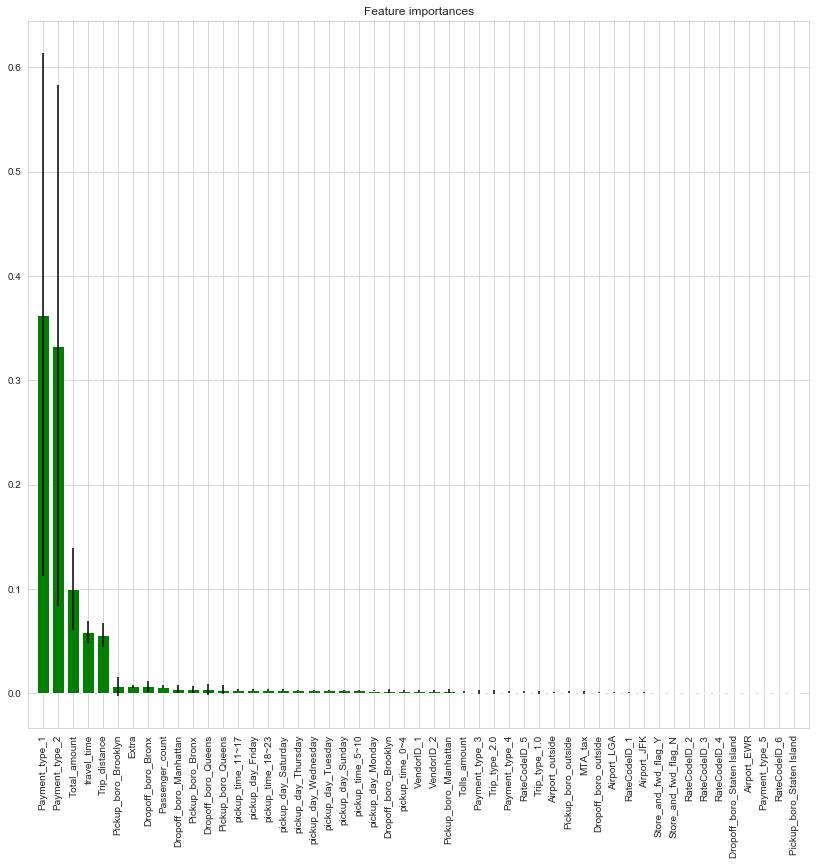

In [36]:
# on Classification model

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix



smaller_X,smaller_Y = Train_Clas_X1.iloc[:30000,:],Train_Clas_Y1.iloc[:30000]

clf_rf = RandomForestClassifier(n_estimators=100)   
clr_rf = clf_rf.fit(smaller_X,smaller_Y)
print('confusion matrix on testing dataset')
print(confusion_matrix(Test_Clas_Y1[:20000], clf_rf.predict(Test_Clas_X1[:20000])))

importances = clr_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
plt.figure(figsize=(14, 13))
plt.title("Feature importances")
plt.bar(range(Train_Clas_X1.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(Train_Clas_X1.shape[1]),Train_Clas_X1.columns[indices],rotation=90)
plt.xlim([-1, Train_Clas_X1.shape[1]])
plt.show()



From the confusion matrix, we could see because of my data preparation, model have pretty decent predictive power and very high accuracy. And the top 8 important feature (multiple dummy variable consider as one variable) seen from here are:
- Payment type
- Total_amount
- travel_time
- Trip_distance
- Pickup_boro
- Dropoff_boro
- Extra
- Passenger count


#### method 2: Tree based feature selection and random forest regressor

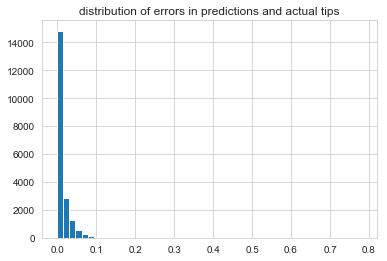

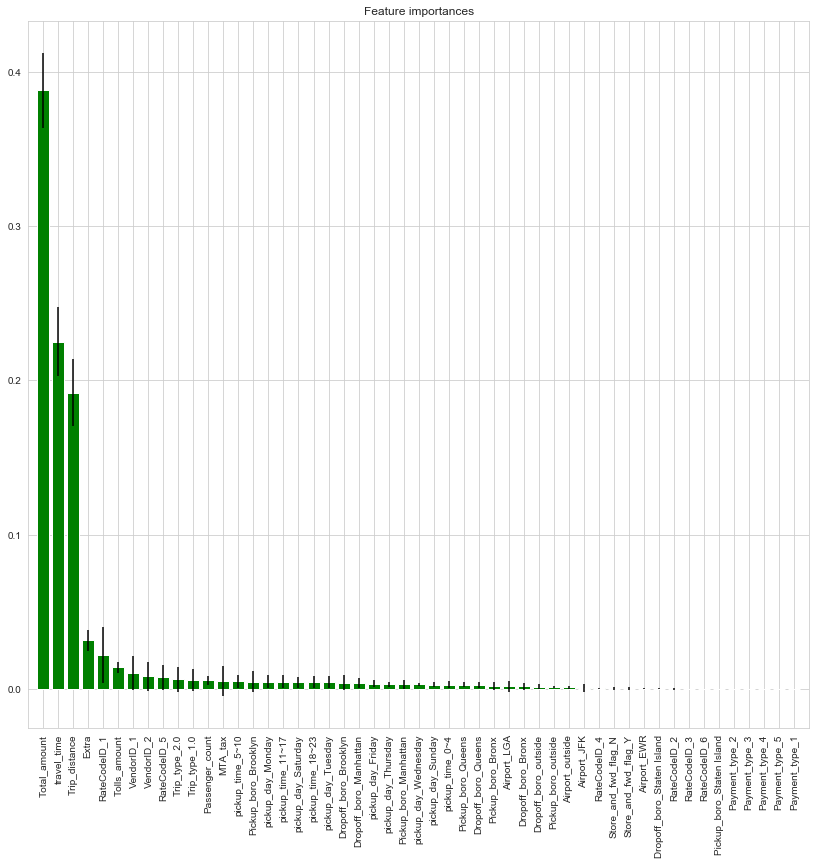

In [37]:
# on regression model

from sklearn.ensemble import RandomForestRegressor
smaller_X,smaller_Y = Train_reg_X1.iloc[:30000,:],Train_reg_Y1.iloc[:30000]

clf_rf = RandomForestRegressor(n_estimators=100)   
clr_rf = clf_rf.fit(smaller_X,smaller_Y)

plt.hist(abs(Test_reg_Y1[:20000].values-clf_rf.predict(Test_reg_X1[:20000])),bins=50)
plt.title('distribution of errors in predictions and actual tips')
plt.show()

importances = clr_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis=0)

indices = np.argsort(importances)[::-1]

plt.figure(1, figsize=(14, 13))
plt.title("Feature importances")
plt.bar(range(Train_reg_X1.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(Train_reg_X1.shape[1]),Train_reg_X1.columns[indices],rotation=90)
plt.xlim([-1, Train_reg_X1.shape[1]])
plt.show()


From the distribution of errors, we could see because of my data preparation, model have pretty decent predictive power and very high accuracy. The disrepency of actual and predicted tip_centage is generally less than 0.02. And the top 8 important feature (multiple dummy variable consider as one variable) seen from here are:

- Total_amount
- Trip_distance
- travel_time
- Extra
- Rate_code
- Tolls_amount
- pickup_time
- pickup_day

**Method 3: lasso regression on regression model and data**
**Combining the finding from above 2 graphs, I decided to keep**

 try alpha=0.00290000000000000023

Text(0.5, 1.0, 'Number of Coefficients')

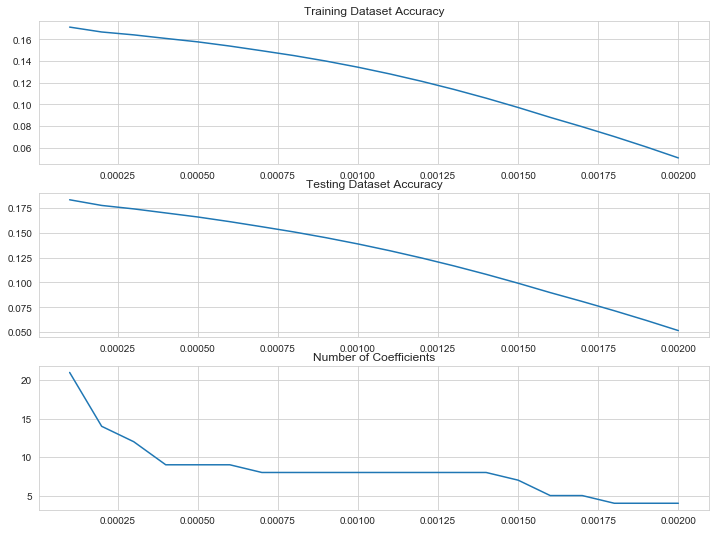

In [38]:
from sklearn.linear_model import Lasso
train_score,test_score,coeff_used=[],[],[]
alphas=[0.0001*i for i in range(1,21)]
for alpha in alphas:
    print('\r try alpha={}'.format(alpha),end='')
    lasso = Lasso(alpha, max_iter=10e5)
    lasso.fit(Train_reg_X1.iloc[:30000,:], Train_reg_Y1.iloc[:30000])
    train_score.append(lasso.score(Train_reg_X1.iloc[:30000,:], Train_reg_Y1.iloc[:30000]))
    test_score.append(lasso.score(Test_reg_X1[:10000], Test_reg_Y1[:10000]))
    coeff_used.append(np.sum(lasso.coef_!=0))
    
plt.figure(figsize=(12,9))
plt.subplot(3,1,1)
plt.plot(alphas,train_score) 
plt.title('Training Dataset Accuracy')
plt.subplot(3,1,2)
plt.plot(alphas,test_score) 
plt.title('Testing Dataset Accuracy')
plt.subplot(3,1,3)
plt.plot(alphas,coeff_used) 
plt.title('Number of Coefficients')

From the graph, I will pick alpha=0.0005 for the lasso regression model. Check the result:


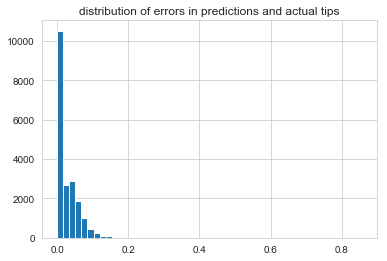

Feature kept are: 

Trip_distance
Extra
Tolls_amount
Total_amount
travel_time
Pickup_boro_Brooklyn
Pickup_boro_Manhattan
Dropoff_boro_Brooklyn
Dropoff_boro_Manhattan


In [39]:
lasso = Lasso(0.0005, max_iter=10e5)
lasso.fit(Train_reg_X1.iloc[:30000,:], Train_reg_Y1.iloc[:30000])
plt.hist(abs(Test_reg_Y1[:20000].values-lasso.predict(Test_reg_X1[:20000])),bins=50)
plt.title('distribution of errors in predictions and actual tips')
plt.show()

result_3=[n for n,i in enumerate(lasso.coef_) if abs(i)>1e-4]
print('Feature kept are: \n')
for i in result_3:
    print(list(Train_reg_X1)[i])

The result is not as good as resemble model, but still it works well in term of discrepency.


#### Conclusion for feature selection:

By the above 3 methods, I decided to kept following 11 features:
Payment type, Total_amount, travel_time, Trip_distance, Extra, Tolls_amount, Pickup_boro, Dropoff_boro, pickup_time, pickup_day, RateCodeID

In [40]:
Final_data = data_for_model.loc[:,['Payment_type', 'Total_amount', 'travel_time',
                                   'Trip_distance', 'Extra', 'Tolls_amount','RateCodeID',
                                   'Pickup_boro', 'Dropoff_boro', 'pickup_time', 'pickup_day','tip_perc']]

Final_data = pd.get_dummies(Final_data, columns=['RateCodeID','Payment_type','pickup_day',
                                                 'pickup_time','Pickup_boro','Dropoff_boro'])
np.random.seed(1)
# shuffle data
Final_data = Final_data.sample(frac=1).reset_index(drop=True)
non_zero_data = Final_data.loc[Final_data['tip_perc']!=0,:]


# classification problem dataset
Data_flag = (Final_data.loc[:,['tip_perc']] != 0).astype(int)
Classification_X = Final_data.drop(columns = ['tip_perc'])

N_data = len(Classification_X)
split  = N_data//5

Train_Clas_X1 = Classification_X.iloc[:(split*3),:]
Test_Clas_X1  = Classification_X.iloc[(3*split):(4*split),:]

Train_Clas_Y1 = Data_flag.iloc[:(split*3)]
Test_Clas_Y1  = Data_flag.iloc[(3*split):(4*split)]


# regression model dataset
Data_Y = non_zero_data['tip_perc']
Data_X = non_zero_data.drop(columns = ['tip_perc'])
N_data = len(non_zero_data)
split  = N_data//5

Train_reg_X1 = Data_X.iloc[:(split*3),:]
Test_reg_X1  = Data_X.iloc[(split*3):(split*4),:]

# for regression model
Train_reg_Y1 = Data_Y.iloc[:(split*3)]
Test_reg_Y1  = Data_Y.iloc[(3*split):(4*split)]


Let's see the accuracy again, to see if reduce number of features significantly reduce accuracy

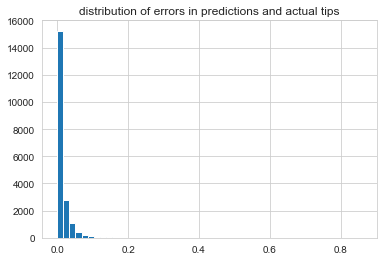

MSE of regression model is: 
0.0008176974065567576


C:\Users\lunarhero\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Confusion matrix on testing dataset
[[11050   798]
 [  107  8045]]
F1 score of the regression model
0.9467490438364224
Accuracy of the regression model
0.95475


In [41]:
# on regression model
from sklearn.metrics import f1_score
smaller_X,smaller_Y = Train_reg_X1.iloc[:30000,:],Train_reg_Y1.iloc[:30000]

clf_rf = RandomForestRegressor(n_estimators=100)   
clr_rf = clf_rf.fit(smaller_X,smaller_Y)

plt.hist(abs(Test_reg_Y1[:20000].values - clf_rf.predict(Test_reg_X1[:20000])),bins=50)
plt.title('distribution of errors in predictions and actual tips')
plt.show()
# mean square error
print('MSE of regression model is: ')
print(np.mean((Test_reg_Y1[:20000].values - clf_rf.predict(Test_reg_X1[:20000]))**2))


# classification model
smaller_X,smaller_Y = Train_Clas_X1.iloc[:30000,:],Train_Clas_Y1.iloc[:30000]
clf_rf = RandomForestClassifier(n_estimators=100)   
clr_rf = clf_rf.fit(smaller_X,smaller_Y)

ma = confusion_matrix(Test_Clas_Y1[:20000], clf_rf.predict(Test_Clas_X1[:20000]))
print('Confusion matrix on testing dataset')
print(ma)

print('F1 score of the regression model')
print(f1_score(Test_Clas_Y1[:20000], clf_rf.predict(Test_Clas_X1[:20000])))

print('Accuracy of the regression model')
print((ma[0,0]+ma[1,1])/np.sum(ma))

We could see the model still perform really well on both models even though we have removed many features. Now lets go to the formal training.

### step 3: model construction and comparison

During the feature selection process, i have accieved 0.948 f1 score on whether pay a tip and MSE of 4.05 on regression problem of how many tips is being paid using only 30K of the data for training. Now let me try one more model to compare the accuracy and also on a larger dataset. So here is the content:
- Formalise the ensemble model: use classfication tree to decide whether pay a tips, then for people who pay, use regression tree to decide what percentage did they paid.
- Use Artifical Neuron network do the same thing. But generally ensemble method works better for this situation of many categorical feature. But I will give a try and make a final decision later.



**Firstly, random forest method:**

In [42]:
# here i only train 100K data for training and 50k data for testing because It will take too long the train all of them
np.random.seed(1) #set seed just to make result consistant   random forest with perform differently with different seed
Final_data = Final_data.sample(frac=1).reset_index(drop=True)

testing_data = Final_data.iloc[-50000:,:]
training_data = Final_data.iloc[:100000,:]

non_zero_train = training_data.loc[training_data['tip_perc']!=0,:]
non_zero_test = testing_data.loc[testing_data['tip_perc']!=0,:]

# classification problem dataset
Train_Clas_Y1 = (training_data.loc[:,['tip_perc']] != 0).astype(int)
Train_Clas_X1 = training_data.drop(columns = ['tip_perc'])

Test_Clas_Y1  = (testing_data.loc[:,['tip_perc']] != 0).astype(int)
Test_Clas_X1  = testing_data.drop(columns = ['tip_perc'])


# regression model dataset
Train_reg_Y1 = non_zero_train.loc[:,['tip_perc']]
Test_reg_Y1  = non_zero_test.loc[:,['tip_perc']]

Train_reg_X1 = non_zero_train.drop(columns = ['tip_perc'])
Test_reg_X1  = non_zero_test.drop(columns = ['tip_perc'])




In [43]:
# training
clf_rf = RandomForestClassifier(n_estimators=100)   
clr_rf = clf_rf.fit(Train_Clas_X1,Train_Clas_Y1.values)
reg_rf = RandomForestRegressor(n_estimators=100)   
reg_rf = reg_rf.fit(Train_reg_X1,Train_reg_Y1.values)

C:\Users\lunarhero\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\lunarhero\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


regression model mse is 0.0012355213251441207


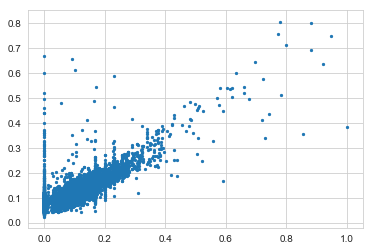

In [44]:
# prediction
output_df = testing_data.copy()
output_df['clf_prediction'] = clf_rf.predict(Test_Clas_X1)
train_data2 = output_df.loc[output_df['clf_prediction']==1,:].drop(columns = ['tip_perc','clf_prediction'])
prediction = reg_rf.predict(train_data2)

print('regression model mse is {}'.format(np.mean((output_df.loc[output_df['clf_prediction']==1,'tip_perc'] - prediction)**2)))
output_df.loc[:,'reg_prediction']=0
output_df.loc[output_df['clf_prediction']==1,'reg_prediction'] = prediction
plt.scatter(output_df.loc[output_df['clf_prediction']==1,'tip_perc'],prediction,s=5)
plt.show()

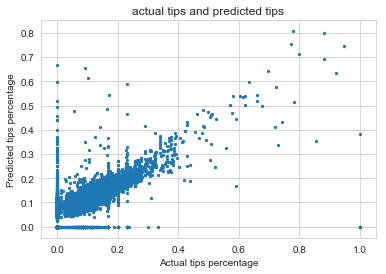

Mean Square Error is 0.0006842738129616408


In [45]:
# check prediction performance
plt.scatter(output_df.tip_perc,output_df.reg_prediction, s = 5)
plt.title('actual tips and predicted tips')
plt.xlabel('Actual tips percentage')
plt.ylabel('Predicted tips percentage')
plt.show()
print('Mean Square Error is {}'.format(np.mean((output_df.tip_perc-output_df.reg_prediction)**2)))

**Secondly, ANN method:**

Firstly, Let me build and tune a classification network

In [51]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.python.data import Dataset
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras import layers
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import BatchNormalization

In [52]:
testing_data = Final_data.iloc[-50000:,:]
training_data = Final_data.iloc[:100000,:]

non_zero_train = training_data.loc[training_data['tip_perc']!=0,:]
non_zero_test = testing_data.loc[testing_data['tip_perc']!=0,:]

# classification problem dataset
Train_Clas_Y1 = (training_data.loc[:,['tip_perc']] != 0).astype(int)
Train_Clas_X1 = training_data.drop(columns = ['tip_perc'])

Test_Clas_Y1  = (testing_data.loc[:,['tip_perc']] != 0).astype(int)
Test_Clas_X1  = testing_data.drop(columns = ['tip_perc'])


# regression model dataset
Train_reg_Y1 = non_zero_train.loc[:,['tip_perc']]
Test_reg_Y1  = non_zero_test.loc[:,['tip_perc']]

Train_reg_X1 = non_zero_train.drop(columns = ['tip_perc'])
Test_reg_X1  = non_zero_test.drop(columns = ['tip_perc'])

In [53]:
# Normalize Training Data 
std_scale = preprocessing.StandardScaler().fit(Train_Clas_X1)

x_train_norm = std_scale.transform(Train_Clas_X1)
#Converting numpy array to dataframe
training_norm_col = pd.DataFrame(x_train_norm, index=Train_Clas_X1.index, columns=Train_Clas_X1.columns) 
Train_Clas_X1.update(training_norm_col)

# Normalize Testing Data by using mean and SD of training set
x_test_norm = std_scale.transform(Test_Clas_X1)
testing_norm_col = pd.DataFrame(x_test_norm, index=Test_Clas_X1.index, columns=Test_Clas_X1.columns) 
Test_Clas_X1.update(testing_norm_col)


x_train_norm = std_scale.transform(Train_reg_X1)
#Converting numpy array to dataframe
training_norm_col = pd.DataFrame(x_train_norm, index=Train_reg_X1.index, columns=Train_reg_X1.columns) 
Train_reg_X1.update(training_norm_col)

# Normalize Testing Data by using mean and SD of training set
x_test_norm = std_scale.transform(Test_reg_X1)
testing_norm_col = pd.DataFrame(x_test_norm, index=Test_reg_X1.index, columns=Test_reg_X1.columns) 
Test_reg_X1.update(testing_norm_col)

C:\Users\lunarhero\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\lunarhero\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
C:\Users\lunarhero\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\lunarhero\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app
C:\Users\lunarhero\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DataConversionWarning: D

#### Model construction and hyper-parameter tuning 
##### Look at number of hidden layer

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
100000/100000 [==============================] - 4s 40us/sample - loss: 0.2216 - acc: 0.9192
Epoch 2/10
100000/100000 [==============================] - 3s 34us/sample - loss: 0.1896 - acc: 0.9274
Epoch 3/10
100000/100000 [==============================] - 3s 34us/sample - loss: 0.1890 - acc: 0.9266
Epoch 4/10
100000/100000 [==============================] - 3s 33us/sample - loss: 0.1861 - acc: 0.9277
Epoch 5/10
100000/100000 [==============================] - 3s 34us/sample - loss: 0.1844 - acc: 0.9278
Epoch 6/10
100000/100000 [==============================] - 3s 35us/sample - loss: 0.1837 - acc: 0.9284
Epoch 7/10
100000/100000 [==============================] - 3s 32us/sample - loss: 0.1830 - acc: 0.9280
Epoch 8/10
100000/100000 [===========

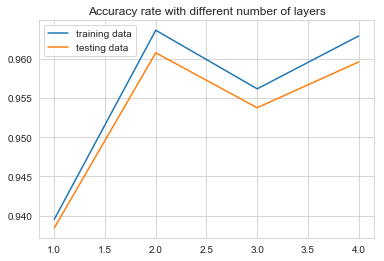

In [54]:
def generate_model(n_hidden,n_size,act):
    model = keras.Sequential(
        [keras.layers.Dropout(0.2, input_shape=(Train_Clas_X1.shape[1],))] +
        [keras.layers.Dense(n_size, activation=act,) for i in range(n_hidden)] + 
        [keras.layers.Dense(1, activation= 'sigmoid')])
    return model

result_train=[]
result_test=[]
t = 5
for k in range(1,t):
    model=generate_model(k,100,'relu')
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    history2 = model.fit(Train_Clas_X1, Train_Clas_Y1,epochs= 10, batch_size = 60)
    prediction=model.predict(Test_Clas_X1)
    # evaluate the model
    _, train_acc = model.evaluate(Train_Clas_X1, Train_Clas_Y1, verbose=0)
    _, test_acc = model.evaluate(Test_Clas_X1, Test_Clas_Y1, verbose=0)
    print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
    result_train.append(train_acc)
    result_test.append(test_acc)
plt.plot([i for i in range(1,t)],result_train,label='training data')
plt.plot([i for i in range(1,t)],result_test,label='testing data')
plt.legend()
plt.title('Accuracy rate with different number of layers')
plt.show()

By looking at the result, I will pick the number of hidden layer being 2.

##### look at number of nodes in each hidden layer


In [55]:
result_train=[]
result_test=[]
for i in range(2):
    # average over independent test
    for k in range(1,7):
        model=generate_model(3,25*k,'relu')
        model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
        history2 = model.fit(Train_Clas_X1, Train_Clas_Y1,epochs= 10, batch_size = 60)
        prediction=model.predict(Test_Clas_X1)
        # evaluate the model
        _, train_acc = model.evaluate(Train_Clas_X1, Train_Clas_Y1, verbose=0)
        _, test_acc = model.evaluate(Test_Clas_X1, Test_Clas_Y1, verbose=0)
        print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
        result_train.append(train_acc)
        result_test.append(test_acc)


Epoch 1/10
100000/100000 [==============================] - 4s 36us/sample - loss: 0.2220 - acc: 0.9128
Epoch 2/10
100000/100000 [==============================] - 3s 28us/sample - loss: 0.1911 - acc: 0.9255
Epoch 3/10
100000/100000 [==============================] - 3s 27us/sample - loss: 0.1846 - acc: 0.9270
Epoch 4/10
100000/100000 [==============================] - 3s 27us/sample - loss: 0.1759 - acc: 0.9292
Epoch 5/10
100000/100000 [==============================] - 3s 28us/sample - loss: 0.1621 - acc: 0.9337
Epoch 6/10
100000/100000 [==============================] - 3s 28us/sample - loss: 0.1519 - acc: 0.9392
Epoch 7/10
100000/100000 [==============================] - 3s 28us/sample - loss: 0.1466 - acc: 0.9423
Epoch 8/10
100000/100000 [==============================] - 3s 26us/sample - loss: 0.1415 - acc: 0.9445
Epoch 9/10
100000/100000 [==============================] - 3s 26us/sample - loss: 0.1358 - acc: 0.9464
Epoch 10/10
100000/100000 [==============================] - 3s 

Epoch 8/10
100000/100000 [==============================] - 5s 49us/sample - loss: 0.1328 - acc: 0.9486
Epoch 9/10
100000/100000 [==============================] - 5s 48us/sample - loss: 0.1294 - acc: 0.9501
Epoch 10/10
100000/100000 [==============================] - 5s 48us/sample - loss: 0.1294 - acc: 0.9495
Train: 0.966, Test: 0.964
Epoch 1/10
100000/100000 [==============================] - 6s 56us/sample - loss: 0.2080 - acc: 0.9211
Epoch 2/10
100000/100000 [==============================] - 5s 50us/sample - loss: 0.1908 - acc: 0.9260
Epoch 3/10
100000/100000 [==============================] - 5s 52us/sample - loss: 0.1801 - acc: 0.9278
Epoch 4/10
100000/100000 [==============================] - 5s 50us/sample - loss: 0.1627 - acc: 0.9333
Epoch 5/10
100000/100000 [==============================] - 5s 50us/sample - loss: 0.1517 - acc: 0.9396
Epoch 6/10
100000/100000 [==============================] - 5s 52us/sample - loss: 0.1409 - acc: 0.9441
Epoch 7/10
100000/100000 [===========

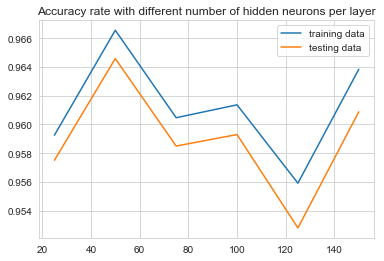

In [56]:
result_train2=(np.array(result_train[:6])+np.array(result_train[6:]))/2
result_test2=(np.array(result_test[:6])+np.array(result_test[6:]))/2
plt.plot([25*i for i in range(1,7)],result_train2,label='training data')
plt.plot([25*i for i in range(1,7)],result_test2,label='testing data')
plt.title('Accuracy rate with different number of hidden neurons per layer')
plt.legend()
plt.show()

From above, I would pick 50 for the number of nodes in each layer

In [58]:


model=generate_model(2,50,'relu')
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history2 = model.fit(Train_Clas_X1, Train_Clas_Y1,epochs= 10, batch_size = 30)
prediction=model.predict(Test_Clas_X1)
# evaluate the model
_, train_acc = model.evaluate(Train_Clas_X1, Train_Clas_Y1, verbose=0)
_, test_acc = model.evaluate(Test_Clas_X1, Test_Clas_Y1, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))


Epoch 1/10
100000/100000 [==============================] - 10s 96us/sample - loss: 0.2082 - acc: 0.9225
Epoch 2/10
100000/100000 [==============================] - 9s 94us/sample - loss: 0.1910 - acc: 0.9255
Epoch 3/10
100000/100000 [==============================] - 9s 92us/sample - loss: 0.1834 - acc: 0.9277
Epoch 4/10
100000/100000 [==============================] - 9s 95us/sample - loss: 0.1731 - acc: 0.9296
Epoch 5/10
100000/100000 [==============================] - 10s 97us/sample - loss: 0.1616 - acc: 0.9347
Epoch 6/10
100000/100000 [==============================] - 9s 92us/sample - loss: 0.1513 - acc: 0.9401
Epoch 7/10
100000/100000 [==============================] - 10s 102us/sample - loss: 0.1421 - acc: 0.9445
Epoch 8/10
100000/100000 [==============================] - 10s 103us/sample - loss: 0.1366 - acc: 0.9467
Epoch 9/10
100000/100000 [==============================] - 11s 105us/sample - loss: 0.1345 - acc: 0.9474
Epoch 10/10
100000/100000 [=============================

Similarly, I have searched for many different parameters for the regression ANN. But the performance was actually all very bad.

In [62]:
def generate_model2(n_hidden,n_size,act):
    model = keras.Sequential(
        [keras.layers.Dropout(0.2, input_shape=(Train_Clas_X1.shape[1],))] +
        [item for sublist in [[keras.layers.Dense(n_size, activation=act),
         BatchNormalization()] for i in range(n_hidden)] for item in sublist] + 
        [keras.layers.Dense(1, activation= 'relu')])
    return model
# give a example parameter
model=generate_model2(3,75,'relu')
model.compile(optimizer="adam", loss="mean_squared_error")
history2 = model.fit(Train_reg_X1, Train_reg_Y1,epochs= 10, batch_size = 50)


Epoch 1/10
40703/40703 [==============================] - 7s 163us/sample - loss: 0.0380
Epoch 2/10
40703/40703 [==============================] - 4s 105us/sample - loss: 0.0252
Epoch 3/10
40703/40703 [==============================] - 4s 109us/sample - loss: 0.0103
Epoch 4/10
40703/40703 [==============================] - 4s 106us/sample - loss: 0.0042
Epoch 5/10
40703/40703 [==============================] - 5s 115us/sample - loss: 0.0033
Epoch 6/10
40703/40703 [==============================] - 5s 117us/sample - loss: 0.0031
Epoch 7/10
40703/40703 [==============================] - 5s 111us/sample - loss: 0.0030
Epoch 8/10
40703/40703 [==============================] - 4s 105us/sample - loss: 0.0030
Epoch 9/10
40703/40703 [==============================] - 4s 107us/sample - loss: 0.0029
Epoch 10/10
40703/40703 [==============================] - 5s 112us/sample - loss: 0.0029


regression model mse is tip_perc    0.002681
dtype: float64


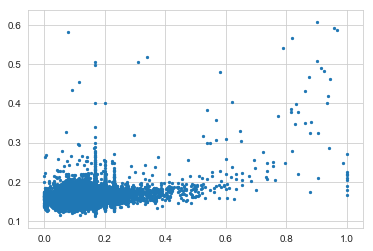

In [63]:
prediction2 = model.predict(Train_reg_X1)
plt.scatter(Train_reg_Y1,prediction2,s=5)
print('regression model mse is {}'.format(np.mean((Train_reg_Y1-prediction2)**2)))

We could see that the performance was actually much worse.

**since the accuracy of ANN model is much small than the random forest method and from the scatter plot they did not form a straight line. I would use the first random foreest method and discard the artifical neural network**


#### Conclusion:
I will pick the method of combinging randomforest regressor and randomforest classifier as my final model and the result is following:


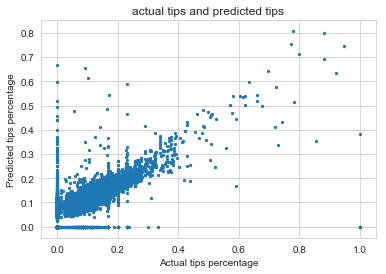

Mean Square Error is 0.0006842738129616408


In [64]:
# check prediction performance

plt.scatter(output_df.tip_perc,output_df.reg_prediction, s = 5)
plt.title('actual tips and predicted tips')
plt.xlabel('Actual tips percentage')
plt.ylabel('Predicted tips percentage')
plt.show()
print('Mean Square Error is {}'.format(np.mean((output_df.tip_perc-output_df.reg_prediction)**2)))

___
___
___
## Question 2: Here I pick topic 2 ---  Visualisation
- Can you build a visualization (interactive or static) of the trip data that helps us understand intra- vs. inter-borough traffic? What story does it tell about how New Yorkers use their green taxis?

If you run the following code, or open run the dashboard.py file, you should able to open a new weblink and following shows:
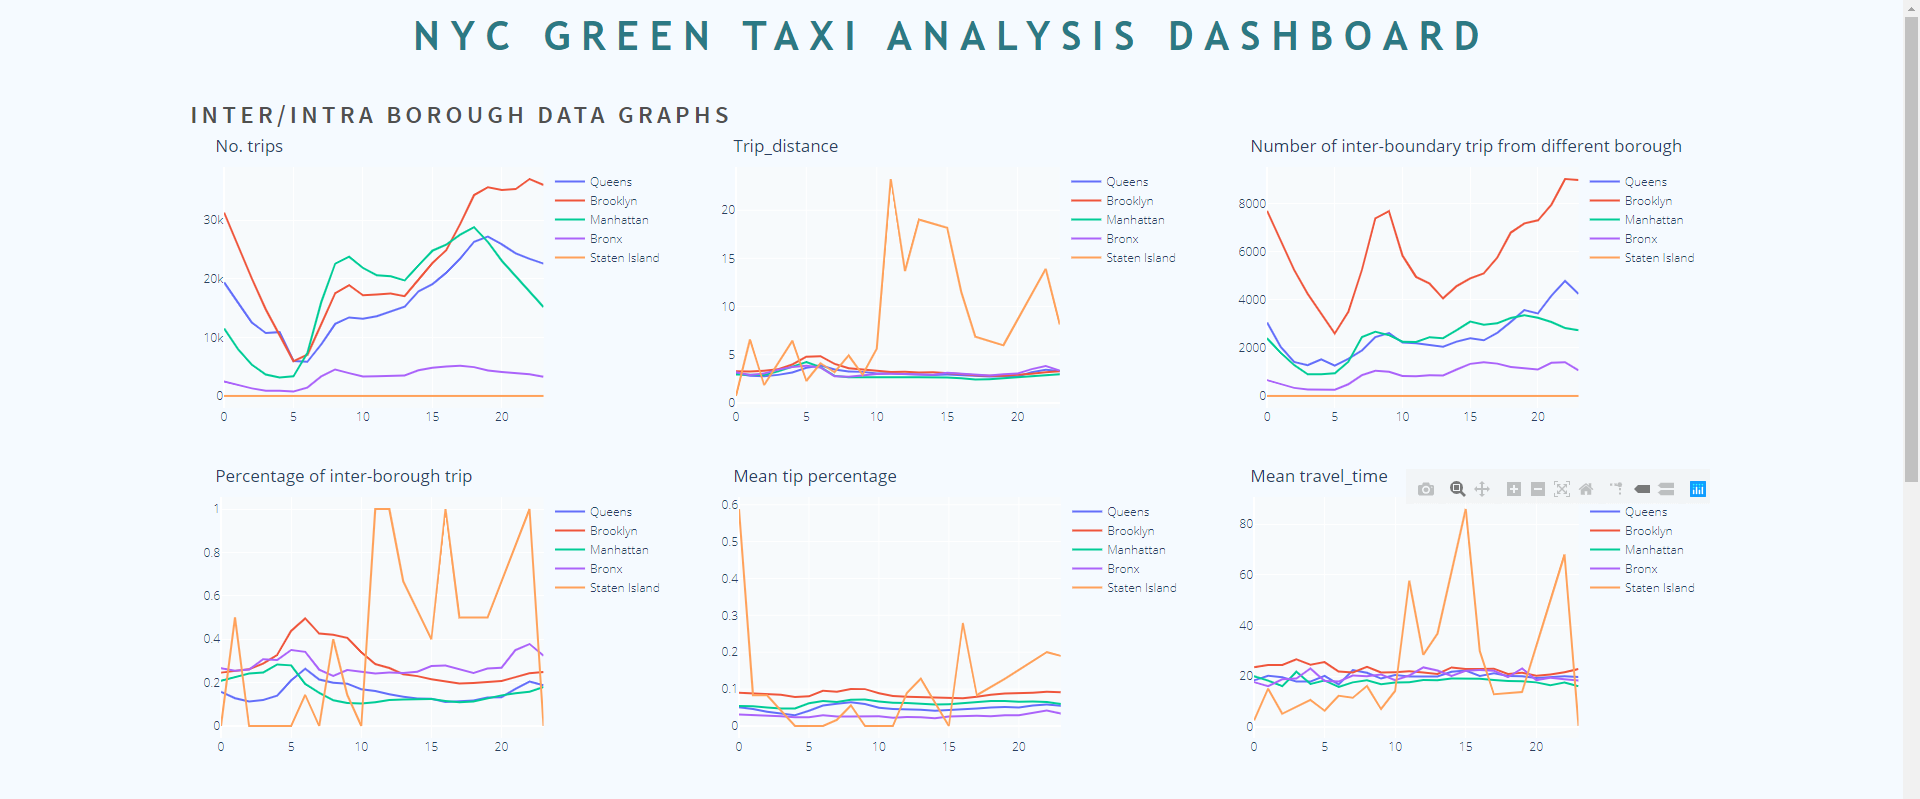
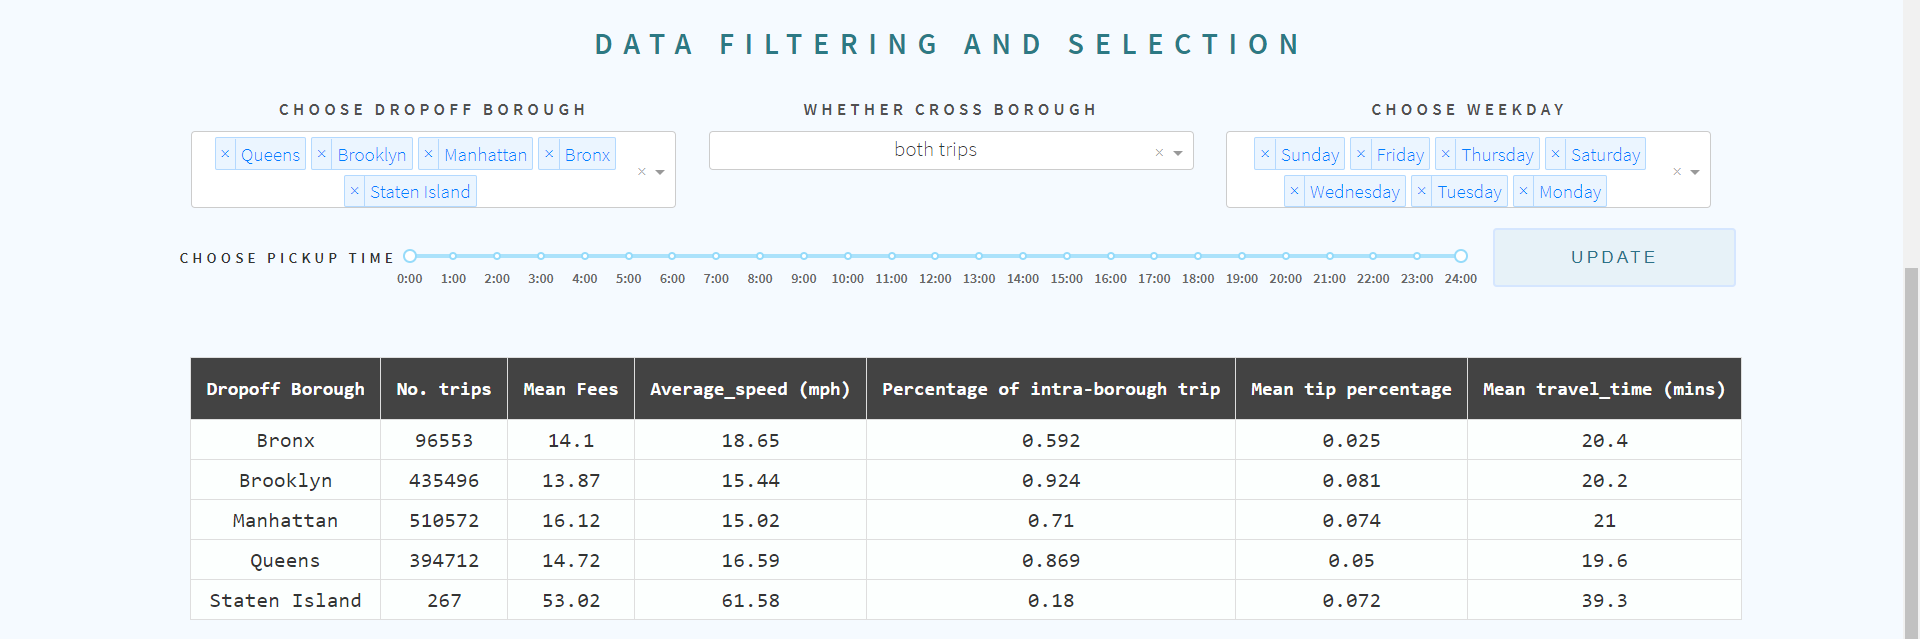
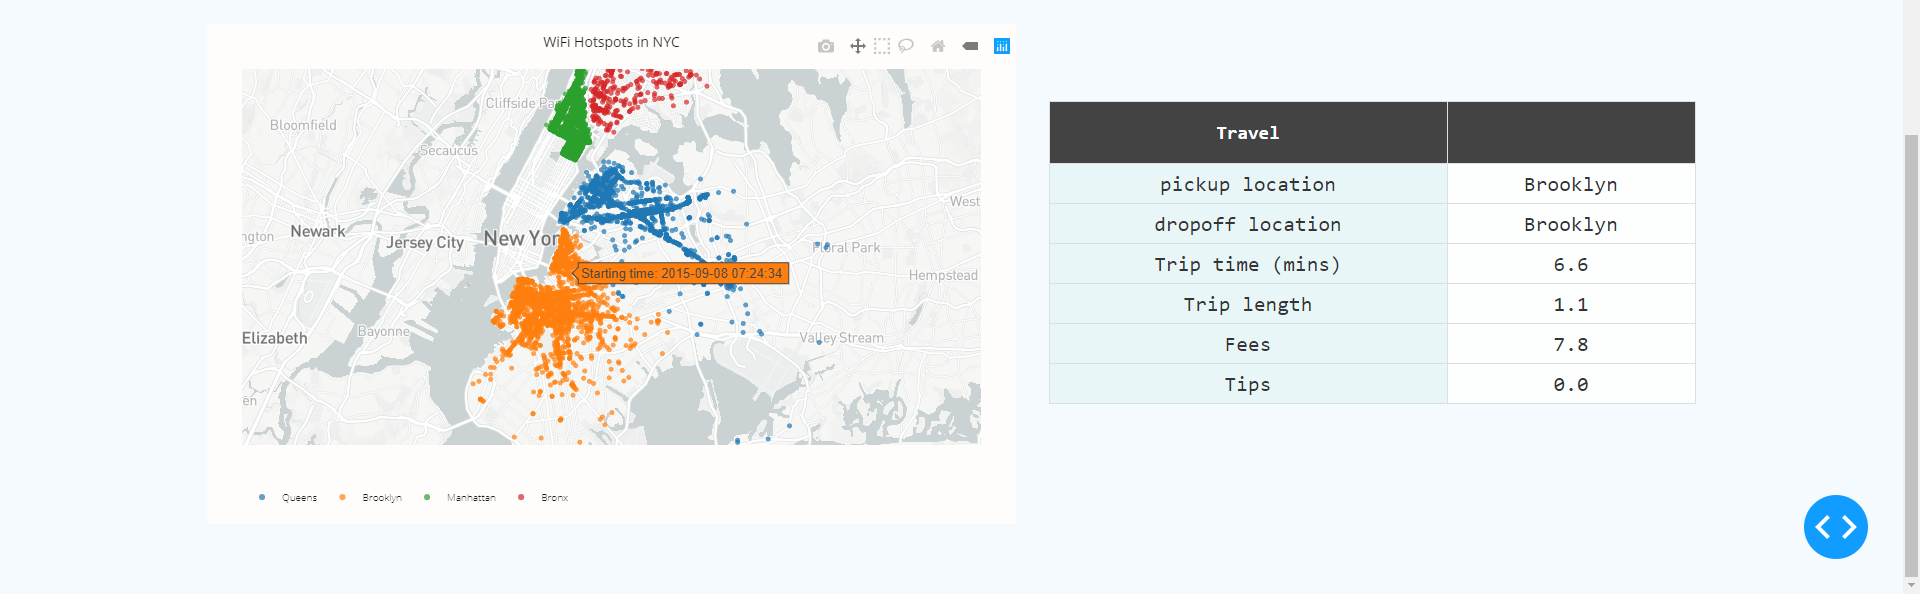

The dashboard will provide interative data analysis for people to look for specific data. The following are the packages needed for running the dashboard. I am using plotly and dash packages.

In [75]:
# cleaned_data is calculated in previous steps 
# cleaned_data = pd.read_csv("cleaned_data.csv")

# make sure you have following module installed
!pip install dash
!pip install plotly
!pip install chartstudio
!pip install dash_daq

  Could not find a version that satisfies the requirement chartstudio (from versions: )
No matching distribution found for chartstudio


  Running setup.py bdist_wheel for dash-daq: started
  Running setup.py bdist_wheel for dash-daq: finished with status 'done'
  Stored in directory: C:\Users\lunarhero\AppData\Local\pip\Cache\wheels\74\43\e0\790d07b2897056ad7f4bf40a63897c66851c0f02c7a7580388
Successfully built dash-daq


To get a better experience, Please run the following codes and then click on "open in a new browser".

Or simply run the python file 'Dashboard.py' if you have already download 'cleaned_data.csv' locally in the same folder. (**not** the original dataset, but the cleaned dataset. You can all call the function **cleaned_data = data_cleaning(original_data)** to generate a new cleaned dataset for dashboard to use)


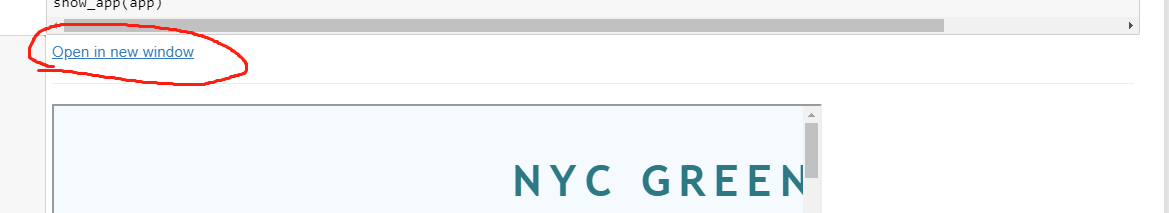


A little video demo if you run from python console directly:

In [67]:
from IPython.display import HTML

HTML("""
<video width="840" height="560" controls>
  <source src="dashboard_demo.mp4" type="video/mp4">
</video>
""")

In [2]:
N_data_show = 11000   # control the number of points on the plot, reduce or increase depend 
                      # on the performance/hardware of your computer 

**IMPORTANT!!!**
The parameter above controls the number of data that is shown in the geomap scatter plot. There is no way of showing all 1.5million data point in the browset without crash your computer. If you run the code below and find the dashboard is a little laggy, reduce the number above to a smaller number. 

For the geomap scatterr plot, i will randomly pick a large number of data from dataset filtered and show in the graph. Because it is randomly selected, it will stil roughly represent the accurate density of trips at different pickup locations


In [3]:
from IPython import display
import os
import dash
import dash_table
import dash_core_components as dcc
import dash_html_components as html
import pandas as pd
import sys
import numpy as np
from plotly import graph_objs as go
from plotly.graph_objs import *
from dash.dependencies import Input, Output, State
import dash_daq as daq
app = dash.Dash(__name__)
server = app.server
app.title = 'NYC Taxi analysis Dashboard'

# API keys and datasets
mapbox_access_token = 'pk.eyJ1IjoibHVuYXJoZXJvIiwiYSI6ImNrNzlqZW9zNjBjYzkzZW1yOTJlNnBsMGQifQ.JukO3NG44HXGSyz_uTSy3A'


dash_data = pd.read_csv('cleaned_data.csv')
#dash_data = cleaned_data.copy()


dash_data = dash_data.sample(frac=1)
dash_data['average_speed'] = dash_data['Trip_distance']/dash_data['travel_time']
dash_data['intra_trip'] =  dash_data['Pickup_boro']==dash_data['Dropoff_boro']
weekdays = dash_data.pickup_day.unique()
time = [0,23]
boroughs = dash_data.Pickup_boro.unique()
intra_trip = ['inter','intra','both']

tabs_styles = {
    'height': '44px',
    "border": "white",
    "primary": "gold",
    "background": "cornsilk"  
}
tab_style = {
    'borderBottom': '1px solid #cee0d8',
    'padding': '6px',
    'fontWeight': 'bold',
    'color':'#2c7984',
    'backgroundColor': '#edf7ff'
}

tab_selected_style = {
    'borderTop': '1px solid #cee0d8',
    'borderBottom': '1px solid #cee0d8',
    'backgroundColor': '#8fabbc',
    'color': 'white',
    'padding': '6px',
    'fontWeight': 'bold'
}

headerColor='#434343'
indexcolumncolor='#e9f6f7'
indexcolumncolor0='#e4f2f0'
valuecolumncolor='#fcfffe'
valuecolumncolor2='#f5fcfb'




def create_table(df1):
    '''
    This is a function that convert pandas dataframe into html display format
    '''
    return dash_table.DataTable(
    data=df1.to_dict('records'),
    columns=[
        {'name': i, 'id': i} for i in df1.columns
    ],
    style_cell={'backgroundColor':valuecolumncolor,'color': '#343434','minWidth':'120px',
                'textAlign': 'center','border':'1px solid #dedede','height':'35',
                'font_size':'10'},
    style_data_conditional=[{
        'if': {'row_index': 'odd'},
        'backgroundColor': valuecolumncolor
        }]+[{
        'if': {'column_id': 'PickUp Borough'},
        'backgroundColor': indexcolumncolor,
    }]+[{
        'if': {'column_id': 'Travel'},
        'backgroundColor': indexcolumncolor,
    }],
    style_header={
        'backgroundColor': headerColor,
        'fontWeight': 'bold',
        'color':'white',
        'height':'42',
        'padding': '15px'
    })




def filter_data(dash_data, weekdays, time, dropoff_loc, intra_trip):
    new_df = []
    for day in weekdays:
        filtered = dash_data.loc[dash_data['pickup_day']==day,:]
        new_df.append(filtered)
    filtered = pd.concat(new_df)
    filtered = filtered.loc[(filtered['pickup_hour']>=time[0]) & (filtered['pickup_hour']<time[1]),:]
    new_df = []
    for item in dropoff_loc:
        filtered2 = filtered.loc[filtered['Dropoff_boro']==item,:]
        new_df.append(filtered2)
        
    filtered = pd.concat(new_df)
    if intra_trip == 'inter':
        filtered = filtered.loc[(filtered['intra_trip']==False) ,:]
    elif intra_trip == 'intra':
        filtered = filtered.loc[(filtered['intra_trip']==True)  ,:]
    return filtered



#  Layouts
layout_table = dict(
    autosize=True,
    height=500,
    font=dict(color="#191A1A"),
    titlefont=dict(color="#191A1A", size='14'),
    margin=dict(
        l=35,
        r=35,
        b=35,
        t=45
    ),
    hovermode="closest",
    plot_bgcolor='#fffcfc',
    paper_bgcolor='#fffcfc',
    legend=dict(font=dict(size=10), orientation='h'),
)
layout_table['font-size'] = '12'
layout_table['margin-top'] = '20'

layout_map = dict(

    height=500,
    font=dict(color="#191A1A"),
    titlefont=dict(color="#191A1A", size='14'),
    margin=dict(
        l=35,
        r=35,
        b=35,
        t=45
    ),
    hovermode="closest",
    plot_bgcolor='#fffcfc',
    paper_bgcolor='#fffcfc',
    legend=dict(font=dict(size=10), orientation='h'),
    title='Taxi Pickup Locations',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        style="light",
        center=dict(
            lon=-73.91251,
            lat=40.7342
        ),
        zoom=10,
    )
)

# functions
def gen_map(map_data,dropoff_loc):
    # groupby returns a dictionary mapping the values of the first field
    # 'classification' onto a list of record dictionaries with that
    # classification value.
    return {
        "data": [{
                "type": "scattermapbox",
                "lat": list(map_data.loc[map_data['Pickup_boro']==i,'Pickup_latitude']),
                "lon": list(map_data.loc[map_data['Pickup_boro']==i,'Pickup_longitude']),
                'customdata': map_data.loc[map_data['Pickup_boro']==i,:].index,
                "hoverinfo": "text",
                "hovertext": [["Starting time: {} ".format(i)] for i in map_data['lpep_pickup_datetime']],
                "mode": "markers",
                "name": i,              
                "marker": {
                    "size": 6,
                    "opacity": 0.7
                
                }
        } for i in dropoff_loc],
        "layout": layout_map
    }


titles=['pickup_hour',
        'No. trips',
        'Trip_distance',
        'Mean travel_speed (mph)',
        'Number of inter-boundary trips from different boroughs',
        'Percentage of inter-borough trip',
        'Mean tip percentage']

dash_data['inter_trip'] =  dash_data['Pickup_boro']!=dash_data['Dropoff_boro']

layout = lambda i: dict(height=300,
                margin=dict(l=20, r=20, t=30, b=20),
                title= titles[i],
                paper_bgcolor='rgba(240,240,240, 0.001)',
                plot_bgcolor='rgba(250,250,250, 0.5)',
                showlegend=True)

def create_figures(boros=['Queens', 'Brooklyn', 'Manhattan', 'Bronx', 'Staten Island']):
    fig1,fig2,fig3 = go.Figure(layout=layout(1)),go.Figure(layout=layout(2)),go.Figure(layout=layout(3))
    fig4,fig5,fig6 = go.Figure(layout=layout(4)),go.Figure(layout=layout(5)),go.Figure(layout=layout(6)) 
    for i in boros:
        selected = dash_data.loc[dash_data['Pickup_boro']==i,:]
        summary_data = pd.pivot_table(selected.loc[:,['tip_perc','inter_trip','intra_trip','Trip_distance','average_speed','pickup_hour','Dropoff_boro']],
                                            index   = ["pickup_hour"],
                                            aggfunc = {'Dropoff_boro':'count',
                                                        'tip_perc':np.mean,
                                                    'intra_trip' :np.mean,
                                                    'inter_trip' :np.sum,
                                                    'Trip_distance':np.mean,
                                                    'average_speed':np.mean
                                                    },
                                        ).reset_index()
        summary_data['intra_trip'] = 1-summary_data['intra_trip'].values
        summary_data['average_speed'] = np.round(summary_data['average_speed']*3600,1)
        summary_data = summary_data.rename(columns={'Dropoff_boro':'No. trips',
                                                        'average_speed' : 'Mean travel_speed (mph)',
                                                        'tip_perc' : 'Mean tip percentage',
                                                        'intra_trip': 'Percentage of inter-borough trip',
                                                        'inter_trip': 'Number of inter-boundary trips from different boroughs'})
        summary_data.loc[summary_data['Mean travel_speed (mph)']>150,'Mean travel_speed (mph)'] = np.nan
        fig1.add_trace(go.Scatter(x=summary_data.pickup_hour, y=summary_data.iloc[:,1], mode='lines', name=i))
        fig2.add_trace(go.Scatter(x=summary_data.pickup_hour, y=summary_data.iloc[:,2], mode='lines', name=i))
        fig3.add_trace(go.Scatter(x=summary_data.pickup_hour, y=summary_data.iloc[:,3], mode='lines', name=i))
        fig4.add_trace(go.Scatter(x=summary_data.pickup_hour, y=summary_data.iloc[:,4], mode='lines', name=i))
        fig5.add_trace(go.Scatter(x=summary_data.pickup_hour, y=summary_data.iloc[:,5], mode='lines', name=i))
        fig6.add_trace(go.Scatter(x=summary_data.pickup_hour, y=summary_data.iloc[:,6], mode='lines', name=i))
    return fig1,fig2,fig3,fig4,fig5,fig6









app.layout = html.Div(
    html.Div([
        html.Div('',style={'width': '2%','height':'30px'}),
        html.H1('NYC Green Taxi Analysis Dashboard',style={'font-size':'40px','textAlign':'center','color':'#2c7984','marginTop':'10px'}),
        html.Div('',style={'width': '2%','height':'30px'}),
        html.H4('Inter/intra borough data graphs',style={'font-size':'25px','color':'#505050','marginLeft':'10%'}),
        html.Div('',style={'width': '2%','height':'10px'}),
        html.Div([
            html.Div('The Staten Island is miss-leading because of limited number of travels',style={'font-size':'15px','color':'#505050'}),
            html.Div([
                html.H6('Show Staten Island Data',style={'font-size':'17px','color':'#505050','width': '25%','display': 'inline-block'}),
                html.Div([daq.BooleanSwitch(
                    id = 'hide_Staten',
                    on = False
                )],style={'width': '10%','display': 'inline-block'})
            ]),
        ],style={'width': '85%','marginLeft':'7.5%','marginRight':'7.5%','vertical-align': 'middle'}),
        dcc.Loading(html.Div(id = '6_plots')),
        html.Div('',style={'width': '2%','height':'20px'}),
        html.H2('Data filtering and selection',style={'font-size':'30px','textAlign':'center','color':'#2c7984','marginTop':'10px'}),
        # Selectors
        html.Div([
            html.Div([
                html.H6('Choose Dropoff Borough',style={'font-size':'17px','color':'#505050'}),
                dcc.Dropdown(
                    id = 'select_borough',
                    options=[
                        {'label': i, 'value': i} for i in boroughs
                    ],
                    multi=True,
                    value = ['Queens', 'Brooklyn', 'Manhattan', 'Bronx', 'Staten Island']
                ),  
            ],style={'width': '30%','display': 'inline-block'}),

            html.Div('',style={'width': '2%','height':'30px','display': 'inline-block'}),

            html.Div([
                html.H6('Whether cross borough',style={'font-size':'17px','color':'#505050'}),
                dcc.Dropdown(
                    id = 'select_trip',
                    options=[
                        {'label': i+' trips', 'value': i} for i in intra_trip
                    ],
                    value='both'
                ),   
            ],style={'width': '30%','display': 'inline-block'}),

            html.Div('',style={'width': '2%','height':'30px','display': 'inline-block'}),

            html.Div([
                html.H6('Choose weekday',style={'font-size':'17px','color':'#505050'}),
                dcc.Dropdown(
                    id = 'select_weekday',
                    options=[
                        {'label': i, 'value': i} for i in weekdays
                    ],
                    multi=True,
                    value=weekdays
                ),  
            ],style={'width': '30%','display': 'inline-block'}),
        ],style={'width': '85%','textAlign':'center','marginLeft':'7.5%','marginRight':'7.5%','vertical-align': 'middle'}),
        html.Div('',style={'width': '2%','height':'20px'}),
        html.Div([
            html.Div([html.H5('Choose Pickup time',style={'color':'#343434'})],style={'width': '15%', 'display': 'inline-block'}),
            html.Div([
                dcc.RangeSlider(
                    id='Select_time',
                    marks={i: {'label':'{}:00'.format(i),'style':{'font-size':'14px','font-weight':'600'}} for i in range(25)}, 
                    min=0, 
                    max=24, 
                    value=[0,24]
                )
            ],style={'width': '65%', 'display': 'inline-block'}),
             html.Div('',style={'width': '2%','height':'30px','display': 'inline-block'}),
            html.Button('Update', id='Update_chart',style={'width': '15%','display': 'inline-block'}),

        ],style={'width': '85%','textAlign':'center','marginLeft':'7.5%','marginRight':'7.5%','vertical-align': 'middle'}),
        html.Div('',style={'width': '2%','height':'70px'}),
        
        html.Div(id='summary_table',style={'width': '80%','textAlign':'center','marginLeft':'10%','marginRight':'10%','vertical-align': 'middle'}),
        # map
        html.Div([
            html.Div([
                dcc.Loading(dcc.Graph(id = 'NYC_map', hoverData={'points': [{'customdata':-1}]}))
            ],style={'width': '50%','display': 'inline-block','vertical-align': 'middle'}),
            html.Div('',style={'width': '2%','height':'30px','display': 'inline-block'}),
            html.Div(id='test1',style={'display': 'inline-block','width': '40%','vertical-align': 'middle'})
        ],style={'width': '85%','textAlign':'center','marginLeft':'7.5%','marginRight':'7.5%','vertical-align': 'middle','display': 'inline-block'}),
        html.Div('',style={'width': '2%','height':'70px'}),


    ]),style={'min-width':'1800px'}
)




@app.callback([Output('NYC_map', 'figure'),
               Output('summary_table', 'children')],
              [Input('Update_chart', 'n_clicks')],
              [State('select_borough', 'value'),
               State('select_trip', 'value'),
               State('select_weekday', 'value'),
               State('Select_time', 'value')])
def loading_dataset(n_clicks, dropoff_loc, intra_trip, weekdays, time):
    new_data = filter_data(dash_data, weekdays, time, dropoff_loc, intra_trip)
    new_data = new_data.sample(frac=1)
    summary_data = pd.pivot_table(new_data.loc[:,['travel_time','Total_amount','Pickup_boro','Dropoff_boro','tip_perc','average_speed','intra_trip']],
                                    index   = ["Dropoff_boro"],
                                    aggfunc = {'Total_amount':np.mean,
                                               'travel_time' :np.mean,
                                               'average_speed':np.mean,
                                               'tip_perc':np.mean,
                                               'Pickup_boro':'count',
                                              },
                                ).reset_index()
    summary_data = summary_data.rename(columns={'Pickup_boro':'No. trips',
                                'Dropoff_boro' : 'Dropoff Borough',
                                                    'Total_amount': 'Mean Fees',
                                                    'travel_time' : 'Mean travel_time (mins)',
                                                    'tip_perc' : 'Mean tip percentage',
                                                    'average_speed': 'Average_speed (mph)'})
    summary_data.iloc[:,2] = np.round(summary_data.iloc[:,2].values,2)
    summary_data.iloc[:,3] = np.round(summary_data.iloc[:,3].values*3600,2)
    summary_data.iloc[:,4] = np.round(summary_data.iloc[:,4].values,3)
    summary_data.iloc[:,5] = np.round(summary_data.iloc[:,5].values/60,1)
    return gen_map(new_data.iloc[:N_data_show,:],dropoff_loc) , create_table(summary_data)

@app.callback(
    Output('6_plots', 'children'),
    [Input('hide_Staten', 'on')])
def hide_staten(choice):
    if choice==False:
        boros=['Queens', 'Brooklyn', 'Manhattan', 'Bronx']
    else:
        boros=['Queens', 'Brooklyn', 'Manhattan', 'Bronx', 'Staten Island']
    
    fig1,fig2,fig3,fig4,fig5,fig6 = create_figures(boros)
    return html.Div([html.Div([
            html.Div([dcc.Graph(figure=fig1)],style={'width': '32%','display': 'inline-block'}),
            html.Div('',style={'width': '2%','height':'30px','display': 'inline-block'}),
            html.Div([dcc.Graph(figure=fig2)],style={'width': '32%','display': 'inline-block'}),
            html.Div('',style={'width': '2%','height':'30px','display': 'inline-block'}),
            html.Div([dcc.Graph(figure=fig3)],style={'width': '32%','display': 'inline-block'}),
        ],style={'width': '85%','textAlign':'center','marginLeft':'7.5%','marginRight':'7.5%','vertical-align': 'middle'}),
        html.Div('',style={'width': '2%','height':'20px'}),
        html.Div([
            html.Div([dcc.Graph(figure=fig4)],style={'width': '32%','display': 'inline-block'}),
            html.Div('',style={'width': '2%','height':'30px','display': 'inline-block'}),
            html.Div([dcc.Graph(figure=fig5)],style={'width': '32%','display': 'inline-block'}),
            html.Div('',style={'width': '2%','height':'30px','display': 'inline-block'}),
            html.Div([dcc.Graph(figure=fig6)],style={'width': '32%','display': 'inline-block'}),
        ],style={'width': '85%','textAlign':'center','marginLeft':'7.5%','marginRight':'7.5%','vertical-align': 'middle'})])

@app.callback(
    Output('test1', 'children'),
    [Input('NYC_map', 'hoverData')])
def update_hover1(hoverData):
    hoverData = hoverData['points'][0]['customdata']
    if hoverData == -1:
        data = pd.DataFrame(np.array([
                        ['pickup location','N/A'],
                        ['dropoff location','N/A'], 
                        ['Trip time (mins)','N/A'], 
                        ['Trip length','N/A'],
                        ['Fees','N/A'],
                        ['Tips','N/A']
                        ]),
                    columns=['Travel', ''])
    else:
        data = pd.DataFrame(np.array([
                        ['pickup location',dash_data.loc[hoverData,'Pickup_boro']],
                        ['dropoff location',dash_data.loc[hoverData,'Dropoff_boro']], 
                        ['Trip time (mins)',np.round(dash_data.loc[hoverData,'travel_time']/60,1)], 
                        ['Trip length',dash_data.loc[hoverData,'Trip_distance']],
                        ['Fees',dash_data.loc[hoverData,'Total_amount']],
                        ['Tips',dash_data.loc[hoverData,'Tip_amount']]
                        ]),
                    columns=['Travel', ''])
    return create_table(data) 


def show_app(app, port = 9999, 
             width = 700, 
             height = 350, 
             offline = False,
            in_binder = None):
    in_binder ='JUPYTERHUB_SERVICE_PREFIX' in os.environ if in_binder is None else in_binder
    if in_binder:
        base_prefix = '{}proxy/{}/'.format(os.environ['JUPYTERHUB_SERVICE_PREFIX'], port)
        url = 'https://hub.mybinder.org{}'.format(base_prefix)
        app.config.requests_pathname_prefix = base_prefix
    else:
        url = 'http://localhost:%d' % port
        
    iframe = '<a href="{url}" target="_new">Open in new window</a><hr><iframe src="{url}" width={width} height={height}></iframe>'.format(url = url, 
                                                                                  width = width, 
                                                                                  height = height)
    
    display.display_html(iframe, raw = True)
    if offline:
        app.css.config.serve_locally = True
        app.scripts.config.serve_locally = True
    return app.run_server(debug=False, # needs to be false in Jupyter
                          host = '0.0.0.0',
                          port=port)
show_app(app)

Open in new window

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:9999/ (Press CTRL+C to quit)
127.0.0.1 - - [03/Mar/2020 00:25:48] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [03/Mar/2020 00:25:48] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [03/Mar/2020 00:25:48] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [03/Mar/2020 00:25:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [03/Mar/2020 00:25:52] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [03/Mar/2020 00:25:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [03/Mar/2020 00:26:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [03/Mar/2020 00:26:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [03/Mar/2020 00:26:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [03/Mar/2020 00:26:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [03/Mar/2020 00:26:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [03/Mar/2020 00:26:06] "POST /_dash-update-component H

127.0.0.1 - - [03/Mar/2020 00:26:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [03/Mar/2020 00:26:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [03/Mar/2020 00:26:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [03/Mar/2020 00:26:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [03/Mar/2020 00:26:52] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [03/Mar/2020 00:26:52] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [03/Mar/2020 00:26:52] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [03/Mar/2020 00:26:52] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [03/Mar/2020 00:27:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [03/Mar/2020 00:27:02] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [03/Mar/2020 00:27:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [03/Mar/2020 00:27:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.

You need to stop the kernal from running above in order to test other codes in this notebook

### Analysis intra-borough traffic


you can hide the line 'Staten island' by clicking on the legend of the graph
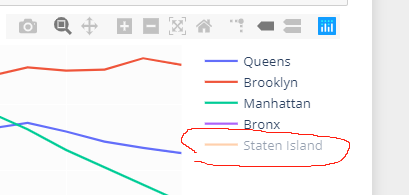

In [ ]:
fig1,fig2,fig3,fig4,fig5,fig6 = create_figures(boros=['Queens', 'Brooklyn', 'Manhattan', 'Bronx', 'Staten Island'])


In [ ]:
fig1.show()
fig4.show()

Observation from two plot above:
- For trips with pickup location in all 5 boroughs, we could see that the total number of trips as well as inter-borough trip is more frequent from 5a.m. to 10a.m. and from 5p.m. to 24p.m. , which is the peak period for people to commute and go to work and home. Hence, we would expect the traffic is heavier in the morning. And all the main road connecting different boroughs will be escpcially heavy. And it will be harder to get a taxi because of higher demand. 
- This will tell New Yorkers that when they would expect a longer waiting time for a taxi and a more difficult traffic.

In [ ]:
fig3.show()

we could see that the traffic speed is faster in thelate night from 3 to 5 a.m. because there is less car on the road. And the traffic is getting heavier and slower in the afternoon and late night. This will tell New Yorkers when the traffic is most slow and worst.


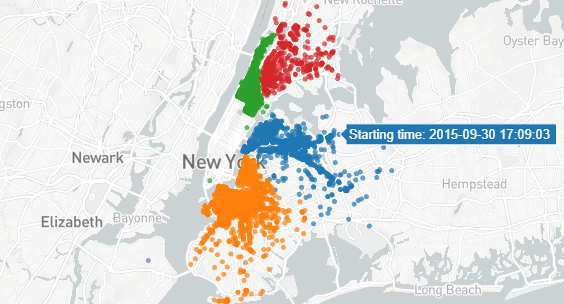

By looking at the scatter plot at different time, we could also see where the most people are picked up and know which area has the highest demand.